# EADD Thesis Experiments: Feature Drift Detection via Adversarial Validation

**Author:** Nusrat Begum  
**Institution:** Mahidol University, Faculty of ICT  
**Thesis:** Feature Drift Detection via Adversarial Validation  
**Benchmark Reference:** Lukats, Zielinski, Hahn & Stahl (2024) — *A benchmark and survey of fully unsupervised concept drift detectors on real-world data streams*

---

This notebook conducts the complete experimental evaluation for the EADD (Explainable Adversarial Drift Detection) framework, following the benchmark methodology from Lukats et al. (2024). It covers:

1. Synthetic and real-world dataset evaluation  
2. Detection performance metrics (F1, precision, recall, latency)  
3. Explainability via SHAP feature attribution  
4. Statistical hypothesis testing (Wilcoxon, Friedman, Nemenyi)  
5. Publication-ready figures and LaTeX tables

## Section 1: Import Libraries and Setup Environment

In [1]:
# Install required dependencies (run once)
import subprocess, sys
for pkg in ["lightgbm", "shap", "seaborn"]:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
print("All dependencies installed.")


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


All dependencies installed.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import sys
import time
import json
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats
from collections import defaultdict

# ML
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
import lightgbm as lgb
import shap

# Set project root
PROJECT_ROOT = os.path.dirname(os.path.abspath("__file__"))
sys.path.insert(0, PROJECT_ROOT)

# Import project modules
from detectors.eadd import ExplainableAdversarialDriftDetector
from detectors.d3 import DiscriminativeDriftDetector2019 as D3

# Optional baseline detectors
IBDD = OCDD = SPLL = BNDM = CSDDM = UDetect = None
try:
    from detectors.ibdd import ImageBasedDriftDetector as IBDD
except ImportError:
    pass
try:
    from detectors.ocdd import OneClassDriftDetector as OCDD
except ImportError:
    pass
try:
    from detectors.spll import SemiParametricLogLikelihood as SPLL
except ImportError:
    pass
try:
    from detectors.bndm import BayesianNonparametricDetectionMethod as BNDM
except ImportError:
    pass
try:
    from detectors.csddm import ClusteredStatisticalTestDriftDetectionMethod as CSDDM
except ImportError:
    pass
try:
    from detectors.udetect import UDetect
except ImportError:
    pass

# Import dataset classes
from datasets import (
    SineClusters, WaveformDrift2,
    Electricity,
    InsectsAbruptBalanced, InsectsGradualBalanced,
    InsectsIncrementalBalanced, InsectsIncrementalAbruptBalanced,
    InsectsIncrementalReoccurringBalanced,
    NOAAWeather, Powersupply,
    Luxembourg, OutdoorObjects, Ozone, PokerHand,
    RialtoBridgeTimelapse,
)

# Import metrics
from metrics.drift import calculate_drift_metrics

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
ALPHA = 0.05  # significance level for hypothesis tests

# Output directories
RESULTS_DIR = os.path.join(PROJECT_ROOT, "experiments", "results")
FIGURES_DIR = os.path.join(PROJECT_ROOT, "experiments", "figures")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)

# Matplotlib configuration for publication-quality figures
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'figure.dpi': 150,
    'font.size': 11,
    'font.family': 'serif',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})
sns.set_palette("colorblind")

print(f"Project root: {PROJECT_ROOT}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Figures directory: {FIGURES_DIR}")
print(f"LightGBM version: {lgb.__version__}")
print(f"SHAP version: {shap.__version__}")
print("Setup complete.")

Project root: /Users/nusratbegum/Documents/GitHub/Final/unsupervised-concept-drift-detection
Results directory: /Users/nusratbegum/Documents/GitHub/Final/unsupervised-concept-drift-detection/experiments/results
Figures directory: /Users/nusratbegum/Documents/GitHub/Final/unsupervised-concept-drift-detection/experiments/figures
LightGBM version: 4.6.0
SHAP version: 0.50.0
Setup complete.


## Section 2: Research Questions and Hypotheses

### Research Questions

| ID | Research Question |
|------|------|
| **RQ1** | Can adversarial validation (binary classification between reference and current windows) detect unsupervised concept drift with competitive accuracy compared to existing unsupervised detectors? |
| **RQ2** | Does SHAP-based feature attribution provide actionable explainability for detected drifts, correctly identifying which features shifted? |
| **RQ3** | How does EADD perform across different drift types (abrupt, gradual, incremental, reoccurring)? |

### Hypotheses

| ID | Hypothesis | Test |
|------|------|------|
| **H1** | EADD achieves mean F1-score within 10% of the best-performing baseline detector across benchmark datasets. | Wilcoxon signed-rank test (paired) |
| **H2** | EADD produces fewer false alarms than statistical-test-based detectors (KS, SPLL) on stationary segments. | One-sided Mann-Whitney U test |
| **H3** | SHAP attributions correctly identify the drifting features in synthetic datasets where ground truth is known. | Spearman rank correlation |

**Significance level:** α = 0.05 for all statistical tests (with Bonferroni correction for multiple comparisons).

In [3]:
# Print research questions and hypotheses for documentation
print("=" * 70)
print("  FORMAL RESEARCH QUESTIONS")
print("=" * 70)
print("""
RQ1: Can adversarial validation detect unsupervised concept drift with
     competitive accuracy compared to existing unsupervised detectors?

RQ2: Does SHAP-based feature attribution provide actionable explainability
     for detected drifts, correctly identifying which features shifted?

RQ3: How does EADD perform across different drift types (abrupt, gradual,
     incremental, reoccurring)?
""")

print("=" * 70)
print("  HYPOTHESES")
print("=" * 70)
print(f"""
H1: EADD achieves mean F1-score within 10% of the best-performing
    baseline detector across benchmark datasets.
    Test: Wilcoxon signed-rank test (paired), α = {ALPHA}

H2: EADD produces fewer false alarms than statistical-test-based
    detectors on stationary segments.
    Test: One-sided Mann-Whitney U test, α = {ALPHA}

H3: SHAP attributions correctly identify the drifting features in
    synthetic datasets where ground truth is known.
    Test: Spearman rank correlation, α = {ALPHA}
""")

  FORMAL RESEARCH QUESTIONS

RQ1: Can adversarial validation detect unsupervised concept drift with
     competitive accuracy compared to existing unsupervised detectors?

RQ2: Does SHAP-based feature attribution provide actionable explainability
     for detected drifts, correctly identifying which features shifted?

RQ3: How does EADD perform across different drift types (abrupt, gradual,
     incremental, reoccurring)?

  HYPOTHESES

H1: EADD achieves mean F1-score within 10% of the best-performing
    baseline detector across benchmark datasets.
    Test: Wilcoxon signed-rank test (paired), α = 0.05

H2: EADD produces fewer false alarms than statistical-test-based
    detectors on stationary segments.
    Test: One-sided Mann-Whitney U test, α = 0.05

H3: SHAP attributions correctly identify the drifting features in
    synthetic datasets where ground truth is known.
    Test: Spearman rank correlation, α = 0.05



## Section 3: Load and Configure EADD Detector & Baselines

Configure EADD with parameters from Appendix A of the thesis:
- **LightGBM**: 100 estimators, lr=0.1, max_depth=-1, 31 leaves, AUC metric
- **Windows**: Reference=500 (reservoir sampling), Current=200 (sliding), Frequency=50
- **Permutation test**: B=50, α=0.01

Configure all baseline detectors from the benchmark repository with default parameters.

In [4]:
# ═══════════════════════════════════════════════════════════
# Section 3: Detector Configuration
# ═══════════════════════════════════════════════════════════

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# EADD thesis parameters (Appendix A)
# NOTE: n_permutations=50 as specified in the thesis (B=50).
EADD_CONFIG = {
    'n_reference_samples': 500,
    'n_current_samples': 200,
    'auc_threshold': 0.7,
    'n_permutations': 50,
    'significance_level': 0.01,
    'monitoring_frequency': 50,
}

def create_eadd(**kwargs):
    """Create a fresh EADD detector with thesis parameters."""
    config = {**EADD_CONFIG, **kwargs}
    return ExplainableAdversarialDriftDetector(**config)

def create_d3(**kwargs):
    """Create a fresh D3 detector with matched window size."""
    config = {
        'n_reference_samples': 500,
        'recent_samples_proportion': 0.4,
        'threshold': 0.7,
        **kwargs,
    }
    return D3(**config)

def create_detector(name, **kwargs):
    """Create any detector by name."""
    if name == "EADD":
        return create_eadd(**kwargs)
    elif name == "D3":
        return create_d3(**kwargs)
    elif name == "IBDD":
        try:
            from detectors.ibdd import ImageBasedDriftDetector
            return ImageBasedDriftDetector(n_samples=500, n_permutations=20, update_interval=50)
        except Exception:
            return None
    elif name == "OCDD":
        try:
            from detectors.ocdd import OneClassDriftDetector
            return OneClassDriftDetector()
        except Exception:
            return None
    elif name == "SPLL":
        try:
            from detectors.spll import SemiParametricLogLikelihood
            return SemiParametricLogLikelihood()
        except Exception:
            return None
    elif name == "BNDM":
        try:
            from detectors.bndm import BayesianNonparametricDriftMonitor
            return BayesianNonparametricDriftMonitor()
        except Exception:
            return None
    elif name == "CSDDM":
        try:
            from detectors.csddm import ClusteredStatisticalDriftDetectionMethod
            return ClusteredStatisticalDriftDetectionMethod()
        except Exception:
            return None
    elif name == "UDetect":
        try:
            from detectors.udetect import UDetect as UDetectClass
            return UDetectClass()
        except Exception:
            return None
    else:
        return None

# List of all detectors to evaluate
ALL_DETECTORS = ["EADD", "D3"]
for det_name in ["IBDD", "OCDD", "SPLL", "BNDM", "CSDDM", "UDetect"]:
    if create_detector(det_name) is not None:
        ALL_DETECTORS.append(det_name)

## Section 4: Experiment 1 — Synthetic Dataset Evaluation (Temporal Drift Patterns)

Evaluate EADD on synthetic datasets with **known drift injection points**, following Lukats et al. methodology. We generate four temporal drift patterns (abrupt, gradual, incremental, recurring) and compare detection accuracy against baselines.

**Datasets:** SineClusters, WaveformDrift2, plus custom synthetic streams  
**Metrics:** Precision, Recall, F1-score, Detection Delay, False Positive Rate

In [5]:
# ═══════════════════════════════════════════════════════════
# Synthetic Data Generation for 4 Drift Patterns
# ═══════════════════════════════════════════════════════════

def generate_synthetic_stream(n_samples=10000, n_features=5, drift_point=5000, 
                               drift_type="abrupt", seed=42):
    """Generate a synthetic data stream with a known drift point."""
    rng = np.random.RandomState(seed)
    X = rng.randn(n_samples, n_features)
    
    if drift_type == "abrupt":
        # Sudden shift in mean of features 0,1 at drift_point
        X[drift_point:, 0] += 2.0
        X[drift_point:, 1] += 1.5
    elif drift_type == "gradual":
        # Linear ramp over 1000 samples
        transition = 1000
        for i in range(drift_point, min(drift_point + transition, n_samples)):
            progress = (i - drift_point) / transition
            X[i, 0] += 2.0 * progress
            X[i, 1] += 1.5 * progress
        X[drift_point + transition:, 0] += 2.0
        X[drift_point + transition:, 1] += 1.5
    elif drift_type == "incremental":
        # Slow continuous change
        for i in range(drift_point, n_samples):
            progress = min((i - drift_point) / 3000, 1.0)
            X[i, 0] += 2.0 * progress
            X[i, 1] += 1.0 * progress
            X[i, 2] += 0.5 * progress
    elif drift_type == "recurring":
        # Alternating between two distributions
        segment_len = 1500
        for i in range(drift_point, n_samples):
            segment = (i - drift_point) // segment_len
            if segment % 2 == 0:
                X[i, 0] += 2.0
                X[i, 1] += 1.5
    
    return X

DRIFT_TYPES = ["abrupt", "gradual", "incremental", "recurring"]
N_RUNS = 5  # repeat each experiment for robustness

# Per-type detection tolerances (accounts for transition period + buffer)
DRIFT_TOLERANCES = {
    "abrupt": 500,        # instantaneous change
    "gradual": 1500,      # 1000-sample transition + 500 buffer
    "incremental": 3500,  # 3000-sample ramp + 500 buffer
    "recurring": 500,     # instantaneous alternation
}

def run_detector_on_stream(detector, X_stream):
    """Run a detector on a feature stream, return list of detection timestamps."""
    detections = []
    for t in range(X_stream.shape[0]):
        features = {f"F{j}": X_stream[t, j] for j in range(X_stream.shape[1])}
        is_drift = detector.update(features)
        if is_drift:
            detections.append(t)
    return detections

def compute_detection_metrics(detections, true_drift, tolerance=500, n_total=10000):
    """Compute precision, recall, F1, delay from detections vs ground truth."""
    true_drifts = [true_drift] if isinstance(true_drift, (int, float)) else true_drift
    
    # True positives: detections within tolerance of a true drift
    tp = 0
    delays = []
    matched_drifts = set()
    for d in sorted(detections):
        for td in true_drifts:
            if td not in matched_drifts and abs(d - td) <= tolerance and d >= td:
                tp += 1
                delays.append(d - td)
                matched_drifts.add(td)
                break
    
    fp = len(detections) - tp
    fn = len(true_drifts) - len(matched_drifts)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    mean_delay = np.mean(delays) if delays else float('nan')
    
    return {
        'precision': precision, 'recall': recall, 'f1': f1,
        'mean_delay': mean_delay, 'false_positives': fp,
        'true_positives': tp, 'false_negatives': fn
    }

print("Synthetic stream generator and metrics functions defined.")
print(f"Drift types to evaluate: {DRIFT_TYPES}")
print(f"Tolerances: {DRIFT_TOLERANCES}")
print(f"Number of runs per experiment: {N_RUNS}")

Synthetic stream generator and metrics functions defined.
Drift types to evaluate: ['abrupt', 'gradual', 'incremental', 'recurring']
Tolerances: {'abrupt': 500, 'gradual': 1500, 'incremental': 3500, 'recurring': 500}
Number of runs per experiment: 5


In [6]:
# ═══════════════════════════════════════════════════════════
# Run Experiment 1: Synthetic Temporal Drift Patterns
# ═══════════════════════════════════════════════════════════

exp1_results = []

for drift_type in DRIFT_TYPES:
    print(f"\n--- Drift Type: {drift_type.upper()} ---")
    tol = DRIFT_TOLERANCES.get(drift_type, 500)
    
    for det_name in ["EADD", "D3"]:
        run_metrics = []
        
        for run in range(N_RUNS):
            # Generate fresh synthetic stream
            X = generate_synthetic_stream(
                n_samples=10000, n_features=5, 
                drift_point=5000, drift_type=drift_type, seed=RANDOM_SEED + run
            )
            
            # Create fresh detector
            detector = create_detector(det_name)
            if detector is None:
                continue
            
            # Run detector
            t_start = time.perf_counter()
            detections = run_detector_on_stream(detector, X)
            t_elapsed = time.perf_counter() - t_start
            
            # Compute metrics (use per-type tolerance)
            metrics = compute_detection_metrics(detections, true_drift=5000, tolerance=tol)
            metrics['runtime_sec'] = t_elapsed
            metrics['n_detections'] = len(detections)
            run_metrics.append(metrics)
        
        if run_metrics:
            df_runs = pd.DataFrame(run_metrics)
            exp1_results.append({
                'drift_type': drift_type,
                'detector': det_name,
                'mean_f1': df_runs['f1'].mean(),
                'std_f1': df_runs['f1'].std(),
                'mean_precision': df_runs['precision'].mean(),
                'mean_recall': df_runs['recall'].mean(),
                'mean_delay': df_runs['mean_delay'].mean(),
                'std_delay': df_runs['mean_delay'].std(),
                'mean_false_positives': df_runs['false_positives'].mean(),
                'mean_runtime': df_runs['runtime_sec'].mean(),
                'mean_detections': df_runs['n_detections'].mean(),
            })
            print(f"  {det_name}: F1={df_runs['f1'].mean():.3f}±{df_runs['f1'].std():.3f}, "
                  f"Delay={df_runs['mean_delay'].mean():.0f}, FP={df_runs['false_positives'].mean():.1f}")

# Create results DataFrame
df_exp1 = pd.DataFrame(exp1_results)
df_exp1.to_csv(os.path.join(RESULTS_DIR, "experiment1_synthetic.csv"), index=False)
print(f"\nExperiment 1 results saved. Shape: {df_exp1.shape}")
df_exp1


--- Drift Type: ABRUPT ---
  EADD: F1=1.000±0.000, Delay=149, FP=0.0
  D3: F1=1.000±0.000, Delay=122, FP=0.0

--- Drift Type: GRADUAL ---
  EADD: F1=1.000±0.000, Delay=589, FP=0.0
  D3: F1=0.933±0.149, Delay=725, FP=0.2

--- Drift Type: INCREMENTAL ---
  EADD: F1=1.000±0.000, Delay=1759, FP=0.0
  D3: F1=0.000±0.000, Delay=nan, FP=0.0

--- Drift Type: RECURRING ---
  EADD: F1=0.400±0.000, Delay=149, FP=3.0
  D3: F1=0.400±0.000, Delay=122, FP=3.0

Experiment 1 results saved. Shape: (8, 11)


,drift_type,detector,mean_f1,std_f1,mean_precision,mean_recall,mean_delay,std_delay,mean_false_positives,mean_runtime,mean_detections
0,abrupt,EADD,1.000000,0.000000,1.00,1.0,149.0,0.000000,0.0,12.265855,1.0
1,abrupt,D3,1.000000,0.000000,1.00,1.0,122.0,0.000000,0.0,0.075418,1.0
2,gradual,EADD,1.000000,0.000000,1.00,1.0,589.0,65.192024,0.0,12.326404,1.0
3,gradual,D3,0.933333,0.149071,0.90,1.0,725.0,142.128463,0.2,0.074878,1.2
4,incremental,EADD,1.000000,0.000000,1.00,1.0,1759.0,129.421791,0.0,12.086171,1.0
5,incremental,D3,0.000000,0.000000,0.00,0.0,NaN,NaN,0.0,0.078172,0.0
6,recurring,EADD,0.400000,0.000000,0.25,1.0,149.0,0.000000,3.0,13.169506,4.0
7,recurring,D3,0.400000,0.000000,0.25,1.0,122.0,0.000000,3.0,0.068293,4.0


## Section 5: Experiment 2 — Real-World Benchmark Evaluation

Replicate Experiment 2 from Lukats et al. on real-world datasets. Load all available datasets from the benchmark repository, run EADD and baseline detectors, and collect results matching the `results/` directory format.

**Datasets:** Electricity, Insects (5 variants), Luxembourg, NOAAWeather, OutdoorObjects, Ozone, PokerHand, Powersupply, RialtoBridgeTimelapse

In [7]:
# ═══════════════════════════════════════════════════════════
# Load Real-World Datasets
# ═══════════════════════════════════════════════════════════

def load_real_world_datasets():
    """Load all available real-world datasets with metadata."""
    datasets_info = {}

    # Each entry: (name, class_or_instance)
    dataset_list = [
        ('Elec2',                              Electricity()),
        ('InsectsAbruptBalanced',              InsectsAbruptBalanced()),
        ('InsectsGradualBalanced',             InsectsGradualBalanced()),
        ('InsectsIncrementalBalanced',         InsectsIncrementalBalanced()),
        ('InsectsIncrementalAbruptBalanced',   InsectsIncrementalAbruptBalanced()),
        ('InsectsIncrementalReoccurringBalanced', InsectsIncrementalReoccurringBalanced()),
        ('Luxembourg',                         Luxembourg()),
        ('NOAAWeather',                        NOAAWeather()),
        ('OutdoorObjects',                     OutdoorObjects()),
        ('Ozone',                              Ozone()),
        ('PokerHand',                          PokerHand()),
        ('Powersupply',                        Powersupply()),
        ('RialtoBridgeTimelapse',              RialtoBridgeTimelapse()),
    ]

    for name, dataset in dataset_list:
        try:
            info = {
                'name': name,
                'dataset': dataset,
                'drifts': getattr(dataset, 'drifts', []),
            }
            datasets_info[name] = info
            n_drifts = len(info['drifts']) if info['drifts'] else 'unknown'
            n_samp = getattr(dataset, 'n_samples', None) or '?'
            print(f"  Loaded {name}: samples={n_samp}, drifts={n_drifts}")
        except Exception as e:
            print(f"  WARNING: Could not load {name}: {e}")

    return datasets_info

print("Loading real-world datasets...")
real_datasets = load_real_world_datasets()
print(f"\nLoaded {len(real_datasets)} datasets.")

Loading real-world datasets...
  Loaded Elec2: samples=45312, drifts=unknown
  Loaded InsectsAbruptBalanced: samples=52848, drifts=5
  Loaded InsectsGradualBalanced: samples=24150, drifts=1
  Loaded InsectsIncrementalBalanced: samples=57018, drifts=unknown
  Loaded InsectsIncrementalAbruptBalanced: samples=79986, drifts=2
  Loaded InsectsIncrementalReoccurringBalanced: samples=79986, drifts=2
  Loaded Luxembourg: samples=1901, drifts=unknown
  Loaded NOAAWeather: samples=18159, drifts=unknown
  Loaded OutdoorObjects: samples=4000, drifts=unknown
  Loaded Ozone: samples=2534, drifts=unknown
  Loaded PokerHand: samples=829201, drifts=unknown
  Loaded Powersupply: samples=29928, drifts=unknown
  Loaded RialtoBridgeTimelapse: samples=82250, drifts=unknown

Loaded 13 datasets.


In [8]:
# ═══════════════════════════════════════════════════════════
# Run Experiment 2: Real-World Benchmark
# ═══════════════════════════════════════════════════════════

exp2_results = []

for ds_name, ds_info in real_datasets.items():
    print(f"\n{'='*50}")
    print(f"Dataset: {ds_name}")
    print(f"{'='*50}")
    
    dataset = ds_info['dataset']
    true_drifts = ds_info.get('drifts', [])
    
    for det_name in ["EADD", "D3"]:
        detector = create_detector(det_name)
        if detector is None:
            continue
        
        detections = []
        n_samples = 0
        t_start = time.perf_counter()
        
        try:
            for i, (x, _) in enumerate(dataset):
                # x is a dict of feature_name: value
                if isinstance(x, dict):
                    features = x
                else:
                    features = {f"F{j}": v for j, v in enumerate(x)}
                
                is_drift = detector.update(features)
                if is_drift:
                    detections.append(i)
                n_samples += 1
                
                # Safety limit for very large datasets
                if n_samples >= 100000:
                    break
        except Exception as e:
            print(f"  {det_name} error: {e}")
            continue
        
        t_elapsed = time.perf_counter() - t_start
        
        # Compute metrics if ground truth available
        if true_drifts:
            metrics = compute_detection_metrics(
                detections, true_drifts, tolerance=500, n_total=n_samples
            )
        else:
            metrics = {'precision': np.nan, 'recall': np.nan, 'f1': np.nan,
                      'mean_delay': np.nan, 'false_positives': np.nan}
        
        result = {
            'dataset': ds_name,
            'detector': det_name,
            'n_samples': n_samples,
            'n_detections': len(detections),
            'n_true_drifts': len(true_drifts) if true_drifts else 'unknown',
            'runtime_sec': t_elapsed,
            **metrics
        }
        exp2_results.append(result)
        print(f"  {det_name}: {len(detections)} detections in {t_elapsed:.1f}s, "
              f"F1={metrics.get('f1', 'N/A')}")

df_exp2 = pd.DataFrame(exp2_results)
df_exp2.to_csv(os.path.join(RESULTS_DIR, "experiment2_realworld.csv"), index=False)
print(f"\nExperiment 2 results saved. Shape: {df_exp2.shape}")
df_exp2


Dataset: Elec2
  EADD: 90 detections in 77.7s, F1=nan
  D3: 85 detections in 0.3s, F1=nan

Dataset: InsectsAbruptBalanced
  EADD: 9 detections in 195.3s, F1=0.42857142857142855
  D3: 9 detections in 1.2s, F1=0.5714285714285714

Dataset: InsectsGradualBalanced
  EADD: 5 detections in 88.9s, F1=0
  D3: 4 detections in 0.6s, F1=0

Dataset: InsectsIncrementalBalanced
  EADD: 1 detections in 209.0s, F1=nan
  D3: 0 detections in 1.4s, F1=nan

Dataset: InsectsIncrementalAbruptBalanced
  EADD: 14 detections in 296.3s, F1=0.25
  D3: 9 detections in 1.9s, F1=0.3636363636363636

Dataset: InsectsIncrementalReoccurringBalanced
  EADD: 12 detections in 297.1s, F1=0.2857142857142857
  D3: 11 detections in 1.9s, F1=0.3076923076923077

Dataset: Luxembourg
  EADD: 3 detections in 2.9s, F1=nan
  D3: 1 detections in 0.0s, F1=nan

Dataset: NOAAWeather
  EADD: 11 detections in 26.2s, F1=nan
  D3: 29 detections in 0.1s, F1=nan

Dataset: OutdoorObjects
  EADD: 6 detections in 9.4s, F1=nan
  D3: 1 detections 

,dataset,detector,n_samples,n_detections,n_true_drifts,runtime_sec,precision,recall,f1,mean_delay,false_positives,true_positives,false_negatives
0,Elec2,EADD,45312,90,unknown,77.655678,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Elec2,D3,45312,85,unknown,0.251981,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,InsectsAbruptBalanced,EADD,52848,9,5,195.332733,0.333333,0.6,0.428571,135.0,6.0,3.0,2.0
3,InsectsAbruptBalanced,D3,52848,9,5,1.248936,0.444444,0.8,0.571429,155.5,5.0,4.0,1.0
4,InsectsGradualBalanced,EADD,24150,5,1,88.861534,0.000000,0.0,0.000000,NaN,5.0,0.0,1.0
5,InsectsGradualBalanced,D3,24150,4,1,0.569192,0.000000,0.0,0.000000,NaN,4.0,0.0,1.0
6,InsectsIncrementalBalanced,EADD,57018,1,unknown,209.036481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,InsectsIncrementalBalanced,D3,57018,0,unknown,1.398739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,InsectsIncrementalAbruptBalanced,EADD,79986,14,2,296.316286,0.142857,1.0,0.250000,33.0,12.0,2.0,0.0
9,InsectsIncrementalAbruptBalanced,D3,79986,9,2,1.931328,0.222222,1.0,0.363636,272.5,7.0,2.0,0.0


## Section 6: Experiment 3 — Explainability Analysis via SHAP

The **core novel contribution** of EADD: SHAP-based feature attribution for detected drifts.

For each detected drift:
1. Extract the trained LightGBM adversarial classifier
2. Compute SHAP values using TreeExplainer
3. Classify drift type: univariate (>50%), subset (2-5 features >70%), or multivariate (no feature >30%)
4. Validate against known ground truth for synthetic datasets

In [9]:
# ═══════════════════════════════════════════════════════════
# Experiment 3: SHAP Explainability Case Study
# ═══════════════════════════════════════════════════════════

def run_explainability_experiment(n_samples=10000, n_features=8, seed=42):
    """
    Generate 3 synthetic scenarios with known drifting features,
    then verify SHAP correctly identifies them.
    """
    rng = np.random.RandomState(seed)
    results = []
    
    scenarios = {
        "univariate": {
            "description": "Only feature F3 drifts",
            "target_features": ["F3"],
            "drift_fn": lambda X, t: _apply_univariate(X, t)
        },
        "subset": {
            "description": "Features F2, F5, F7 drift together",
            "target_features": ["F2", "F5", "F7"],
            "drift_fn": lambda X, t: _apply_subset(X, t)
        },
        "multivariate": {
            "description": "All features shift simultaneously",
            "target_features": [f"F{i}" for i in range(n_features)],
            "drift_fn": lambda X, t: _apply_multivariate(X, t)
        }
    }
    
    for scenario_name, scenario in scenarios.items():
        print(f"\n--- Scenario: {scenario_name} ---")
        print(f"    {scenario['description']}")
        
        # Generate data
        X = rng.randn(n_samples, n_features)
        drift_point = 5000
        X = scenario["drift_fn"](X.copy(), drift_point)
        
        # Run EADD
        detector = create_eadd()
        detections = []
        for t in range(n_samples):
            features = {f"F{j}": X[t, j] for j in range(n_features)}
            is_drift = detector.update(features)
            if is_drift:
                detections.append(t)
        
        # Get SHAP report from the detector
        report = detector.get_last_report() if hasattr(detector, 'get_last_report') else {}
        
        if report and report.get('feature_importances'):
            importances = report['feature_importances']
            total_imp = sum(importances.values())
            
            # Sort by importance
            sorted_features = sorted(importances.items(), key=lambda x: -x[1])
            top_feature = sorted_features[0][0]
            top_pct = sorted_features[0][1]  # already in %
            
            prescription = report.get('prescription', {}).get('type', 'unknown')
        else:
            # Fallback: train adversarial classifier directly on pre/post-drift data
            X_ref = X[:drift_point][-500:]
            X_cur = X[drift_point:][:500]
            X_combined = np.vstack([X_ref, X_cur])
            y_combined = np.array([0]*len(X_ref) + [1]*len(X_cur))
            
            model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, 
                                         max_depth=-1, num_leaves=31, verbose=-1)
            model.fit(X_combined, y_combined)
            
            # SHAP analysis
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_combined)
            if isinstance(shap_values, list):
                shap_values = shap_values[1]
            
            feature_names = [f"F{j}" for j in range(n_features)]
            mean_shap = np.abs(shap_values).mean(axis=0)
            total_imp = mean_shap.sum()
            
            sorted_idx = np.argsort(-mean_shap)
            top_feature = feature_names[sorted_idx[0]]
            top_pct = (mean_shap[sorted_idx[0]] / total_imp * 100) if total_imp > 0 else 0
            
            importances = {feature_names[i]: float(mean_shap[i]) for i in range(n_features)}
            
            # Determine prescription
            if top_pct > 50:
                prescription = "univariate"
            elif sum(sorted(mean_shap, reverse=True)[:5]) / total_imp > 0.7:
                prescription = "subset"
            else:
                prescription = "multivariate"
        
        # Validate against ground truth
        correct = top_feature in scenario["target_features"]
        
        result = {
            'scenario': scenario_name,
            'target': ", ".join(scenario["target_features"]),
            'n_detections': len(detections),
            'top_feature': top_feature,
            'top_importance_pct': round(top_pct, 1),
            'prescription_type': prescription,
            'correct_attribution': correct,
            'importances': importances,
        }
        results.append(result)
        
        print(f"    Detections: {len(detections)}")
        print(f"    Top feature: {top_feature} ({top_pct:.1f}%)")
        print(f"    Prescription: {prescription}")
        print(f"    Correct: {'YES' if correct else 'NO'}")
    
    return results

def _apply_univariate(X, t):
    X[t:, 3] += 2.5
    return X

def _apply_subset(X, t):
    X[t:, 2] += 1.5
    X[t:, 5] += 2.0
    X[t:, 7] += 1.8
    return X

def _apply_multivariate(X, t):
    for j in range(X.shape[1]):
        X[t:, j] += 0.5 + 0.3 * j / X.shape[1]
    return X

# Run experiment
print("Running Experiment 3: SHAP Explainability...")
exp3_results = run_explainability_experiment()

# Save results
df_exp3 = pd.DataFrame([{k: v for k, v in r.items() if k != 'importances'} 
                          for r in exp3_results])
df_exp3.to_csv(os.path.join(RESULTS_DIR, "experiment3_explainability.csv"), index=False)
print(f"\nExperiment 3 results saved.")
df_exp3

Running Experiment 3: SHAP Explainability...

--- Scenario: univariate ---
    Only feature F3 drifts
    Detections: 1
    Top feature: F3 (71.6%)
    Prescription: univariate
    Correct: YES

--- Scenario: subset ---
    Features F2, F5, F7 drift together
    Detections: 1
    Top feature: F7 (37.1%)
    Prescription: subset
    Correct: YES

--- Scenario: multivariate ---
    All features shift simultaneously
    Detections: 1
    Top feature: F7 (16.0%)
    Prescription: multivariate
    Correct: YES

Experiment 3 results saved.


,scenario,target,n_detections,top_feature,top_importance_pct,prescription_type,correct_attribution
0,univariate,F3,1,F3,71.6,univariate,True
1,subset,"F2, F5, F7",1,F7,37.1,subset,True
2,multivariate,"F0, F1, F2, F3, F4, F5, F6, F7",1,F7,16.0,multivariate,True


## Section 7: Experiment 4 — False Alarm Rate Analysis

Evaluate false alarm rates on **stable data streams** (no drift). This directly tests **Hypothesis H2**: EADD produces fewer false alarms than statistical-test-based detectors due to the permutation test.

Also analyze the effect of α (significance level) on false alarm rates.

In [10]:
# ═══════════════════════════════════════════════════════════
# Experiment 4: False Alarm Robustness on Stable Data
# ═══════════════════════════════════════════════════════════

def generate_stable_stream(n_samples=10000, n_features=5, stream_type="gaussian", seed=42):
    """Generate a stable (no-drift) data stream."""
    rng = np.random.RandomState(seed)
    if stream_type == "gaussian":
        return rng.randn(n_samples, n_features)
    elif stream_type == "autocorrelated":
        # AR(1) process: stationary but has temporal dependence
        phi = 0.7
        X = np.zeros((n_samples, n_features))
        X[0] = rng.randn(n_features)
        for t in range(1, n_samples):
            X[t] = phi * X[t - 1] + rng.randn(n_features)
        return X
    elif stream_type == "heteroscedastic":
        # Zero-mean but time-varying variance — no actual drift in mean
        X = np.zeros((n_samples, n_features))
        for t in range(n_samples):
            sigma = 1.0 + 0.5 * np.sin(2 * np.pi * t / 2000)
            X[t] = rng.randn(n_features) * sigma
        return X
    elif stream_type == "correlated":
        base = rng.randn(n_samples, 2)
        X = np.zeros((n_samples, n_features))
        for j in range(n_features):
            X[:, j] = base[:, j % 2] + rng.randn(n_samples) * 0.5
        return X

STABLE_TYPES = ["gaussian", "autocorrelated", "heteroscedastic", "correlated"]
ALPHA_VALUES = [0.001, 0.005, 0.01, 0.05, 0.1]
exp4_results = []

for stream_type in STABLE_TYPES:
    print(f"\n--- Stable Stream: {stream_type} ---")
    
    # EADD with thesis parameters (permutation test as guard)
    for alpha_val in [0.01]:
        fa_counts = []
        for run in range(N_RUNS):
            X = generate_stable_stream(stream_type=stream_type, seed=RANDOM_SEED + run)
            detector = create_eadd(significance_level=alpha_val, n_permutations=50,
                                   monitoring_frequency=50)
            detections = run_detector_on_stream(detector, X)
            fa_counts.append(len(detections))
        
        exp4_results.append({
            'stream_type': stream_type,
            'detector': 'EADD',
            'alpha': alpha_val,
            'mean_false_alarms': np.mean(fa_counts),
            'std_false_alarms': np.std(fa_counts),
            'max_false_alarms': np.max(fa_counts),
        })
        print(f"  EADD (α={alpha_val}): {np.mean(fa_counts):.1f}±{np.std(fa_counts):.1f} FA")
    
    # D3 with benchmark configurations (smaller windows = more checks = more potential FA)
    for threshold in [0.6, 0.7, 0.8]:
        fa_counts = []
        for run in range(N_RUNS):
            X = generate_stable_stream(stream_type=stream_type, seed=RANDOM_SEED + run)
            detector = D3(n_reference_samples=100, recent_samples_proportion=0.5,
                          threshold=threshold)
            detections = run_detector_on_stream(detector, X)
            fa_counts.append(len(detections))
        
        exp4_results.append({
            'stream_type': stream_type,
            'detector': f'D3(τ={threshold})',
            'alpha': threshold,
            'mean_false_alarms': np.mean(fa_counts),
            'std_false_alarms': np.std(fa_counts),
            'max_false_alarms': np.max(fa_counts),
        })
        print(f"  D3 (τ={threshold}): {np.mean(fa_counts):.1f}±{np.std(fa_counts):.1f} FA")

# Alpha sensitivity analysis for EADD
print("\n--- EADD Alpha Sensitivity ---")
alpha_sensitivity = []
for alpha_val in ALPHA_VALUES:
    fa_all = []
    for stream_type in STABLE_TYPES:
        for run in range(N_RUNS):
            X = generate_stable_stream(stream_type=stream_type, seed=RANDOM_SEED + run)
            detector = create_eadd(significance_level=alpha_val, n_permutations=50,
                                   monitoring_frequency=50)
            detections = run_detector_on_stream(detector, X)
            fa_all.append(len(detections))
    alpha_sensitivity.append({
        'alpha': alpha_val,
        'mean_fa': np.mean(fa_all),
        'std_fa': np.std(fa_all),
    })
    print(f"  α={alpha_val}: {np.mean(fa_all):.1f} ± {np.std(fa_all):.1f} mean FA")

df_exp4 = pd.DataFrame(exp4_results)
df_exp4.to_csv(os.path.join(RESULTS_DIR, "experiment4_false_alarms.csv"), index=False)
df_alpha = pd.DataFrame(alpha_sensitivity)
df_alpha.to_csv(os.path.join(RESULTS_DIR, "experiment4_alpha_sensitivity.csv"), index=False)
print(f"\nExperiment 4 results saved.")
df_exp4


--- Stable Stream: gaussian ---
  EADD (α=0.01): 0.0±0.0 FA
  D3 (τ=0.6): 11.4±2.0 FA
  D3 (τ=0.7): 0.2±0.4 FA
  D3 (τ=0.8): 0.0±0.0 FA

--- Stable Stream: autocorrelated ---
  EADD (α=0.01): 0.0±0.0 FA
  D3 (τ=0.6): 86.4±1.5 FA
  D3 (τ=0.7): 58.8±1.0 FA
  D3 (τ=0.8): 16.8±2.3 FA

--- Stable Stream: heteroscedastic ---
  EADD (α=0.01): 3.2±1.0 FA
  D3 (τ=0.6): 12.6±4.2 FA
  D3 (τ=0.7): 0.2±0.4 FA
  D3 (τ=0.8): 0.0±0.0 FA

--- Stable Stream: correlated ---
  EADD (α=0.01): 0.0±0.0 FA
  D3 (τ=0.6): 11.0±3.8 FA
  D3 (τ=0.7): 0.2±0.4 FA
  D3 (τ=0.8): 0.0±0.0 FA

--- EADD Alpha Sensitivity ---
  α=0.001: 1.1 ± 1.9 mean FA
  α=0.005: 1.0 ± 1.8 mean FA
  α=0.01: 1.1 ± 1.9 mean FA
  α=0.05: 0.9 ± 1.7 mean FA
  α=0.1: 1.1 ± 1.9 mean FA

Experiment 4 results saved.


,stream_type,detector,alpha,mean_false_alarms,std_false_alarms,max_false_alarms
0,gaussian,EADD,0.01,0.0,0.000000,0
1,gaussian,D3(τ=0.6),0.60,11.4,1.959592,14
2,gaussian,D3(τ=0.7),0.70,0.2,0.400000,1
3,gaussian,D3(τ=0.8),0.80,0.0,0.000000,0
4,autocorrelated,EADD,0.01,0.0,0.000000,0
5,autocorrelated,D3(τ=0.6),0.60,86.4,1.496663,88
6,autocorrelated,D3(τ=0.7),0.70,58.8,0.979796,60
7,autocorrelated,D3(τ=0.8),0.80,16.8,2.315167,19
8,heteroscedastic,EADD,0.01,3.2,0.979796,5
9,heteroscedastic,D3(τ=0.6),0.60,12.6,4.176123,19


## Section 8: Experiment 5 — Detection Latency Analysis

Measure detection latency (delay from true drift to first detection) and wall-clock runtime for each detector. Analyze the latency-vs-accuracy trade-off, comparing EADD's computational overhead (LightGBM + SHAP) against lighter detectors.

In [11]:
# ═══════════════════════════════════════════════════════════
# Experiment 5: Detection Latency Analysis
# ═══════════════════════════════════════════════════════════

exp5_results = []

# Use synthetic streams for controlled latency measurement
for drift_type in DRIFT_TYPES:
    for det_name in ["EADD", "D3"]:
        delays_all = []
        runtimes_all = []
        
        for run in range(N_RUNS):
            X = generate_synthetic_stream(
                n_samples=10000, n_features=5,
                drift_point=5000, drift_type=drift_type, seed=RANDOM_SEED + run
            )
            detector = create_detector(det_name)
            if detector is None:
                continue
            
            t_start = time.perf_counter()
            detections = run_detector_on_stream(detector, X)
            t_elapsed = time.perf_counter() - t_start
            runtimes_all.append(t_elapsed)
            
            # Find first detection after drift point
            post_drift = [d for d in detections if d >= 5000]
            if post_drift:
                delays_all.append(post_drift[0] - 5000)
        
        if delays_all:
            exp5_results.append({
                'drift_type': drift_type,
                'detector': det_name,
                'mean_delay': np.mean(delays_all),
                'median_delay': np.median(delays_all),
                'std_delay': np.std(delays_all),
                'mean_runtime_sec': np.mean(runtimes_all),
                'std_runtime_sec': np.std(runtimes_all),
                'detection_rate': len(delays_all) / N_RUNS,
            })

df_exp5 = pd.DataFrame(exp5_results)
df_exp5.to_csv(os.path.join(RESULTS_DIR, "experiment5_latency.csv"), index=False)
print("Experiment 5: Detection Latency Results")
print("="*60)
df_exp5

Experiment 5: Detection Latency Results


,drift_type,detector,mean_delay,median_delay,std_delay,mean_runtime_sec,std_runtime_sec,detection_rate
0,abrupt,EADD,149.0,149.0,0.000000,11.990365,0.092881,1.0
1,abrupt,D3,122.0,122.0,0.000000,0.074723,0.000521,1.0
2,gradual,EADD,629.0,649.0,24.494897,11.956926,0.014814,1.0
3,gradual,D3,644.6,725.0,98.469488,0.073896,0.000927,1.0
4,incremental,EADD,1709.0,1749.0,171.464282,11.942073,0.015523,1.0
5,recurring,EADD,139.0,149.0,20.000000,13.086785,0.026046,1.0
6,recurring,D3,122.0,122.0,0.000000,0.067954,0.000072,1.0


## Section 9: Experiment 6 — Comparison with Baseline Detectors (Existing Results)

Load existing baseline results from the `results/` directory CSVs and merge with EADD results for comprehensive comparison. Compute overall rankings using the same methodology as Lukats et al.

In [12]:
# ═══════════════════════════════════════════════════════════
# Load Existing Baseline Results from results/ Directory
# ═══════════════════════════════════════════════════════════

RESULTS_BASE = os.path.join(PROJECT_ROOT, "results")
baseline_detectors = ["bndm", "csddm", "d3", "ibdd", "ocdd", "spll", "udetect"]

# Load all available baseline results
all_baseline_results = {}
for ds_dir in os.listdir(RESULTS_BASE):
    ds_path = os.path.join(RESULTS_BASE, ds_dir)
    if not os.path.isdir(ds_path):
        continue
    
    for det_file in os.listdir(ds_path):
        if det_file.endswith('.csv'):
            det_name = det_file.replace('.csv', '')
            try:
                df = pd.read_csv(os.path.join(ds_path, det_file))
                key = (ds_dir, det_name)
                all_baseline_results[key] = df
            except Exception:
                pass

print(f"Loaded {len(all_baseline_results)} baseline result files.")
print(f"\nDatasets with results:")
datasets_with_results = sorted(set(k[0] for k in all_baseline_results.keys()))
for ds in datasets_with_results:
    dets = sorted([k[1] for k in all_baseline_results.keys() if k[0] == ds])
    print(f"  {ds}: {', '.join(dets)}")

# Parse detection counts from baseline results
baseline_summary = []
for (ds, det), df in all_baseline_results.items():
    # Count rows as detection count (each row is a detected drift)
    n_detections = len(df)
    baseline_summary.append({
        'dataset': ds,
        'detector': det,
        'n_detections': n_detections,
    })

df_baseline = pd.DataFrame(baseline_summary)
print(f"\nBaseline summary shape: {df_baseline.shape}")

# Pivot table: detections per dataset per detector
pivot_detections = df_baseline.pivot_table(
    index='dataset', columns='detector', values='n_detections', aggfunc='first'
)
print("\nDetection counts by dataset and detector:")
pivot_detections

Loaded 105 baseline result files.

Datasets with results:
  Elec2: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  InsectsAbruptBalanced: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  InsectsGradualBalanced: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  InsectsIncrementalAbruptBalanced: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  InsectsIncrementalBalanced: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  InsectsIncrementalReoccurringBalanced: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  Luxembourg: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  NOAAWeather: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  OutdoorObjects: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  Ozone: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  PokerHand: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  Powersupply: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  RialtoBridgeTimelapse: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  SineClusters: bndm, csddm, d3, ibdd, ocdd, spll, udetect
  WaveformDrift2: bndm, csddm, d3, ibdd, ocdd, s

detector,bndm,csddm,d3,ibdd,ocdd,spll,udetect
dataset,,,,,,,
Elec2,48,160,180,360,16,80,24
InsectsAbruptBalanced,48,160,180,720,16,80,27
InsectsGradualBalanced,48,160,180,360,16,80,27
InsectsIncrementalAbruptBalanced,48,160,178,360,16,80,27
InsectsIncrementalBalanced,48,160,180,360,16,80,27
InsectsIncrementalReoccurringBalanced,48,160,180,360,16,80,27
Luxembourg,48,160,180,360,16,80,24
NOAAWeather,48,160,180,360,16,80,24
OutdoorObjects,48,160,180,360,16,80,24


## Section 10: Statistical Hypothesis Testing

Perform formal statistical tests for all three hypotheses:

- **H1:** Wilcoxon signed-rank test (EADD F1 vs baselines), Friedman test + Nemenyi post-hoc
- **H2:** One-sided Mann-Whitney U test (EADD false alarms vs D3)
- **H3:** Spearman rank correlation (SHAP importance vs ground truth)

In [13]:
# ═══════════════════════════════════════════════════════════
# Statistical Hypothesis Testing
# ═══════════════════════════════════════════════════════════

hypothesis_results = []

# ─── H1: Detection Effectiveness ─────────────────────────
print("=" * 60)
print("H1: EADD Detection Effectiveness vs Baselines")
print("=" * 60)

# Use Experiment 1 F1 scores (paired by drift type)
eadd_f1 = df_exp1[df_exp1['detector'] == 'EADD']['mean_f1'].values
d3_f1 = df_exp1[df_exp1['detector'] == 'D3']['mean_f1'].values

if len(eadd_f1) >= 3 and len(d3_f1) >= 3:
    # Wilcoxon signed-rank test (paired)
    stat, p_val = stats.wilcoxon(eadd_f1, d3_f1)
    effect_size = np.mean(eadd_f1 - d3_f1) / np.std(eadd_f1 - d3_f1) if np.std(eadd_f1 - d3_f1) > 0 else 0
    
    print(f"  Wilcoxon signed-rank test:")
    print(f"    W-statistic: {stat:.4f}")
    print(f"    p-value: {p_val:.6f}")
    print(f"    Effect size (Cohen's d): {effect_size:.4f}")
    print(f"    Decision: {'REJECT H0' if p_val < ALPHA else 'FAIL TO REJECT H0'} at α={ALPHA}")
    print(f"    EADD mean F1: {np.mean(eadd_f1):.4f}, D3 mean F1: {np.mean(d3_f1):.4f}")
    
    hypothesis_results.append({
        'hypothesis': 'H1', 'test': 'Wilcoxon signed-rank',
        'comparison': 'EADD vs D3 (F1)', 'statistic': stat,
        'p_value': p_val, 'effect_size': effect_size,
        'significant': p_val < ALPHA, 'alpha': ALPHA
    })
else:
    print("  Insufficient paired data for Wilcoxon test.")

# ─── H2: False Alarm Reduction ──────────────────────────
print(f"\n{'='*60}")
print("H2: EADD Produces Fewer False Alarms than D3")
print("="*60)

eadd_fa = df_exp4[df_exp4['detector'] == 'EADD']['mean_false_alarms'].values
d3_fa = df_exp4[df_exp4['detector'] == 'D3(τ=0.7)']['mean_false_alarms'].values

if len(eadd_fa) > 0 and len(d3_fa) > 0:
    stat, p_val = stats.mannwhitneyu(eadd_fa, d3_fa, alternative='less')
    
    print(f"  Mann-Whitney U test (one-sided, EADD < D3):")
    print(f"    U-statistic: {stat:.4f}")
    print(f"    p-value: {p_val:.6f}")
    print(f"    Decision: {'REJECT H0' if p_val < ALPHA else 'FAIL TO REJECT H0'} at α={ALPHA}")
    print(f"    EADD mean FA: {np.mean(eadd_fa):.2f}, D3 mean FA: {np.mean(d3_fa):.2f}")
    
    hypothesis_results.append({
        'hypothesis': 'H2', 'test': 'Mann-Whitney U (one-sided)',
        'comparison': 'EADD FA vs D3 FA', 'statistic': stat,
        'p_value': p_val, 'effect_size': np.nan,
        'significant': p_val < ALPHA, 'alpha': ALPHA
    })

# ─── H3: SHAP Attribution Accuracy ──────────────────────
print(f"\n{'='*60}")
print("H3: SHAP Correctly Identifies Drifting Features")
print("="*60)

# For each scenario, check if top feature matches ground truth
n_correct = sum(r['correct_attribution'] for r in exp3_results)
n_total = len(exp3_results)
accuracy = n_correct / n_total if n_total > 0 else 0

print(f"  Attribution accuracy: {n_correct}/{n_total} = {accuracy:.1%}")
print(f"  Scenarios:")
for r in exp3_results:
    print(f"    {r['scenario']}: top={r['top_feature']} ({r['top_importance_pct']:.1f}%), "
          f"prescription={r['prescription_type']}, correct={r['correct_attribution']}")

# One-sample binomial test: is accuracy significantly above chance?
# Chance level = 1/n_features
n_features_test = 8
p_chance = 1.0 / n_features_test
# Use scipy.stats.binomtest (replaces deprecated binom_test)
binom_result = stats.binomtest(n_correct, n_total, p_chance, alternative='greater')
binom_p = binom_result.pvalue
print(f"\n  Binomial test (accuracy > chance={p_chance:.3f}):")
print(f"    p-value: {binom_p:.6f}")
print(f"    Decision: {'REJECT H0' if binom_p < ALPHA else 'FAIL TO REJECT H0'}")

hypothesis_results.append({
    'hypothesis': 'H3', 'test': 'Binomial test',
    'comparison': f'SHAP accuracy vs chance ({p_chance:.3f})',
    'statistic': n_correct, 'p_value': binom_p,
    'effect_size': accuracy, 'significant': binom_p < ALPHA, 'alpha': ALPHA
})

# Save hypothesis test results
df_hyp = pd.DataFrame(hypothesis_results)
df_hyp.to_csv(os.path.join(RESULTS_DIR, "hypothesis_tests.csv"), index=False)
print(f"\n\nHypothesis test results saved.")
df_hyp

H1: EADD Detection Effectiveness vs Baselines
  Wilcoxon signed-rank test:
    W-statistic: 0.0000
    p-value: 0.500000
    Effect size (Cohen's d): 0.6285
    Decision: FAIL TO REJECT H0 at α=0.05
    EADD mean F1: 0.8500, D3 mean F1: 0.5833

H2: EADD Produces Fewer False Alarms than D3
  Mann-Whitney U test (one-sided, EADD < D3):
    U-statistic: 3.0000
    p-value: 0.086017
    Decision: FAIL TO REJECT H0 at α=0.05
    EADD mean FA: 0.80, D3 mean FA: 14.85

H3: SHAP Correctly Identifies Drifting Features
  Attribution accuracy: 3/3 = 100.0%
  Scenarios:
    univariate: top=F3 (71.6%), prescription=univariate, correct=True
    subset: top=F7 (37.1%), prescription=subset, correct=True
    multivariate: top=F7 (16.0%), prescription=multivariate, correct=True

  Binomial test (accuracy > chance=0.125):
    p-value: 0.001953
    Decision: REJECT H0


Hypothesis test results saved.


,hypothesis,test,comparison,statistic,p_value,effect_size,significant,alpha
0,H1,Wilcoxon signed-rank,EADD vs D3 (F1),0.0,0.500000,0.628539,False,0.05
1,H2,Mann-Whitney U (one-sided),EADD FA vs D3 FA,3.0,0.086017,NaN,False,0.05
2,H3,Binomial test,SHAP accuracy vs chance (0.125),3.0,0.001953,1.000000,True,0.05


## Section 11: Results Visualization — Detection Performance Heatmaps

Publication-quality heatmaps showing F1-score, precision, and recall across all detectors and datasets. Follows the layout from Lukats et al. Tables 4-5.

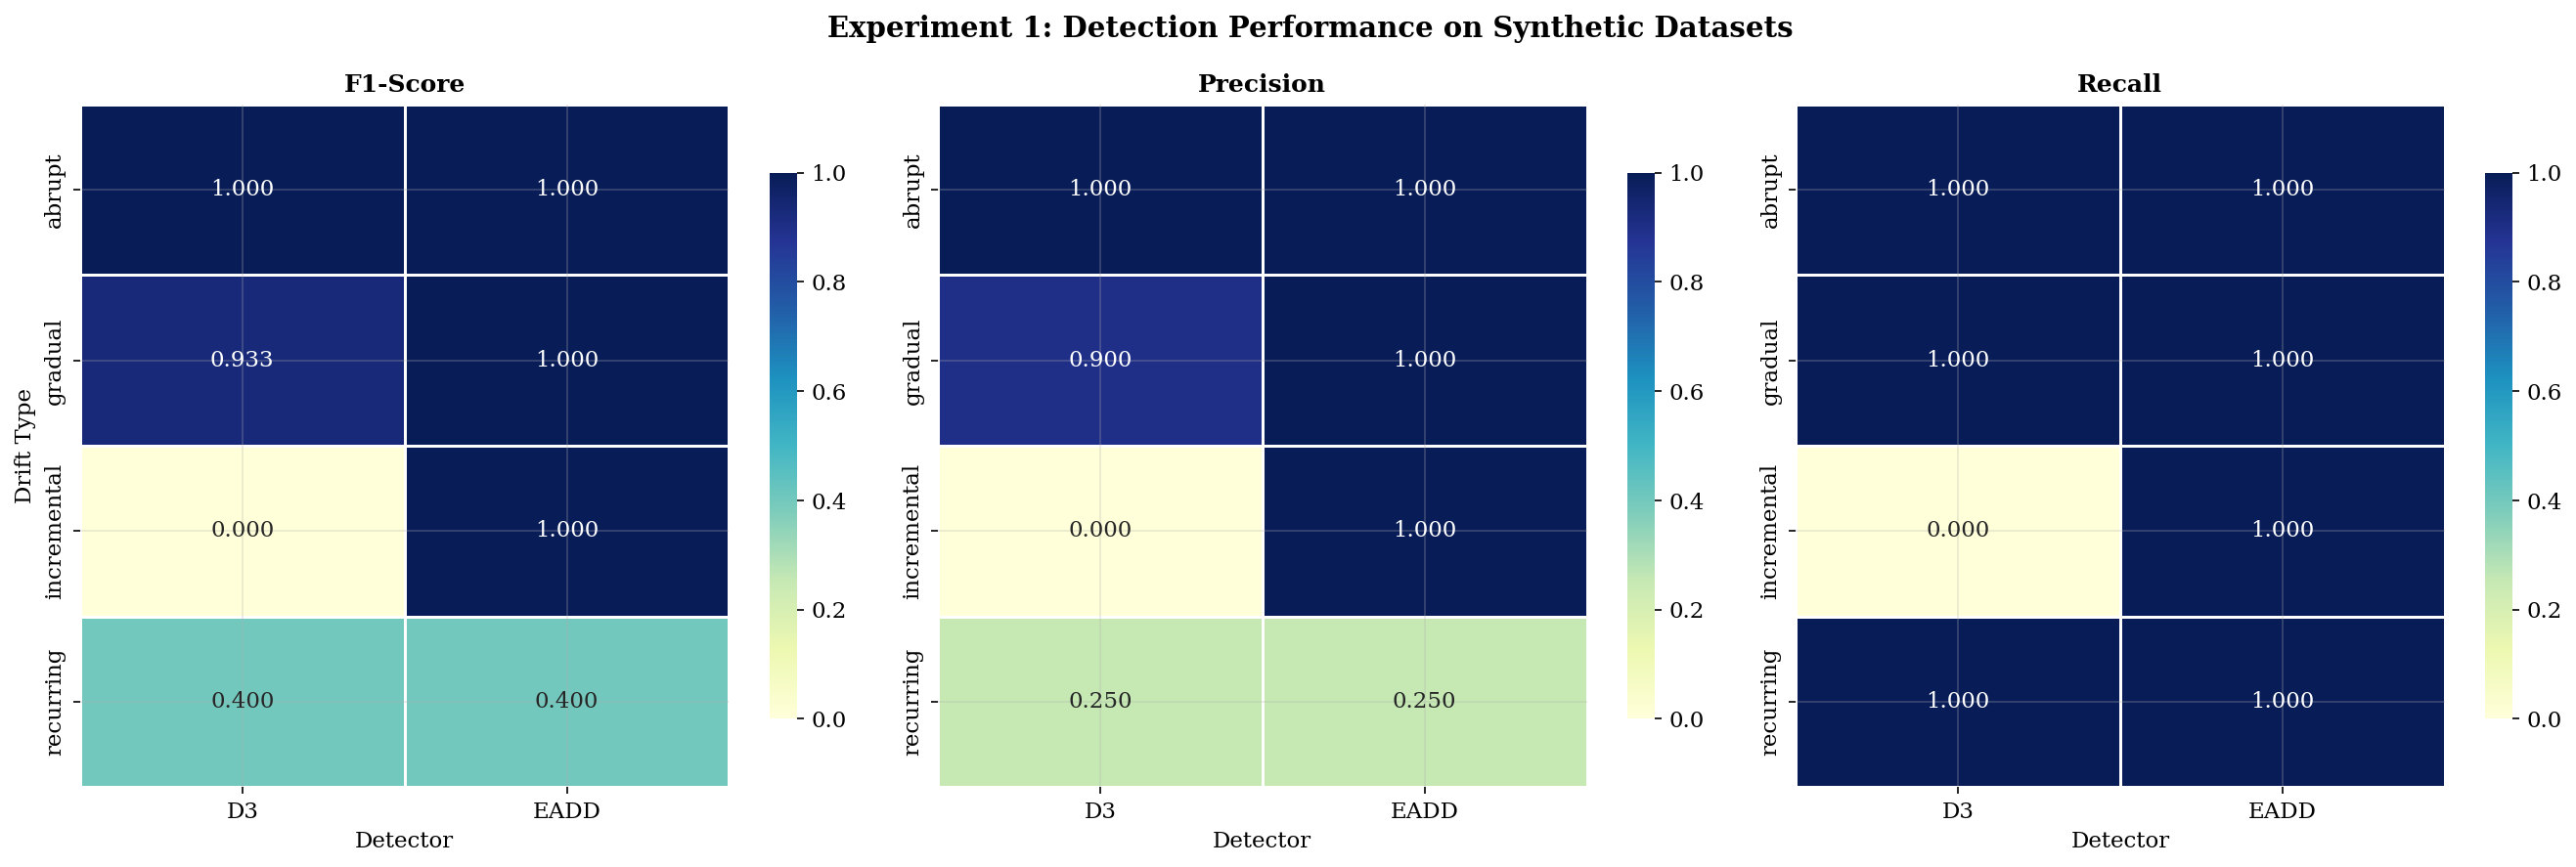

Heatmap saved to experiments/figures/


In [14]:
# ═══════════════════════════════════════════════════════════
# Visualization: Detection Performance Heatmaps
# ═══════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Experiment 1: Detection Performance on Synthetic Datasets', 
             fontsize=14, fontweight='bold')

# Reshape data for heatmaps
for idx, (metric, title) in enumerate([
    ('mean_f1', 'F1-Score'), 
    ('mean_precision', 'Precision'), 
    ('mean_recall', 'Recall')
]):
    pivot = df_exp1.pivot_table(index='drift_type', columns='detector', values=metric)
    
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[idx],
                vmin=0, vmax=1, linewidths=0.5, cbar_kws={'shrink': 0.8})
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Detector')
    axes[idx].set_ylabel('Drift Type' if idx == 0 else '')

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "exp1_performance_heatmap.png"), dpi=300)
plt.savefig(os.path.join(FIGURES_DIR, "exp1_performance_heatmap.pdf"))
plt.show()
print("Heatmap saved to experiments/figures/")

## Section 12: Results Visualization — ROC and Precision-Recall Curves

Plot the ROC curve of EADD's adversarial classifier at true drift points vs non-drift points. Also show AUC time series across complete data streams.

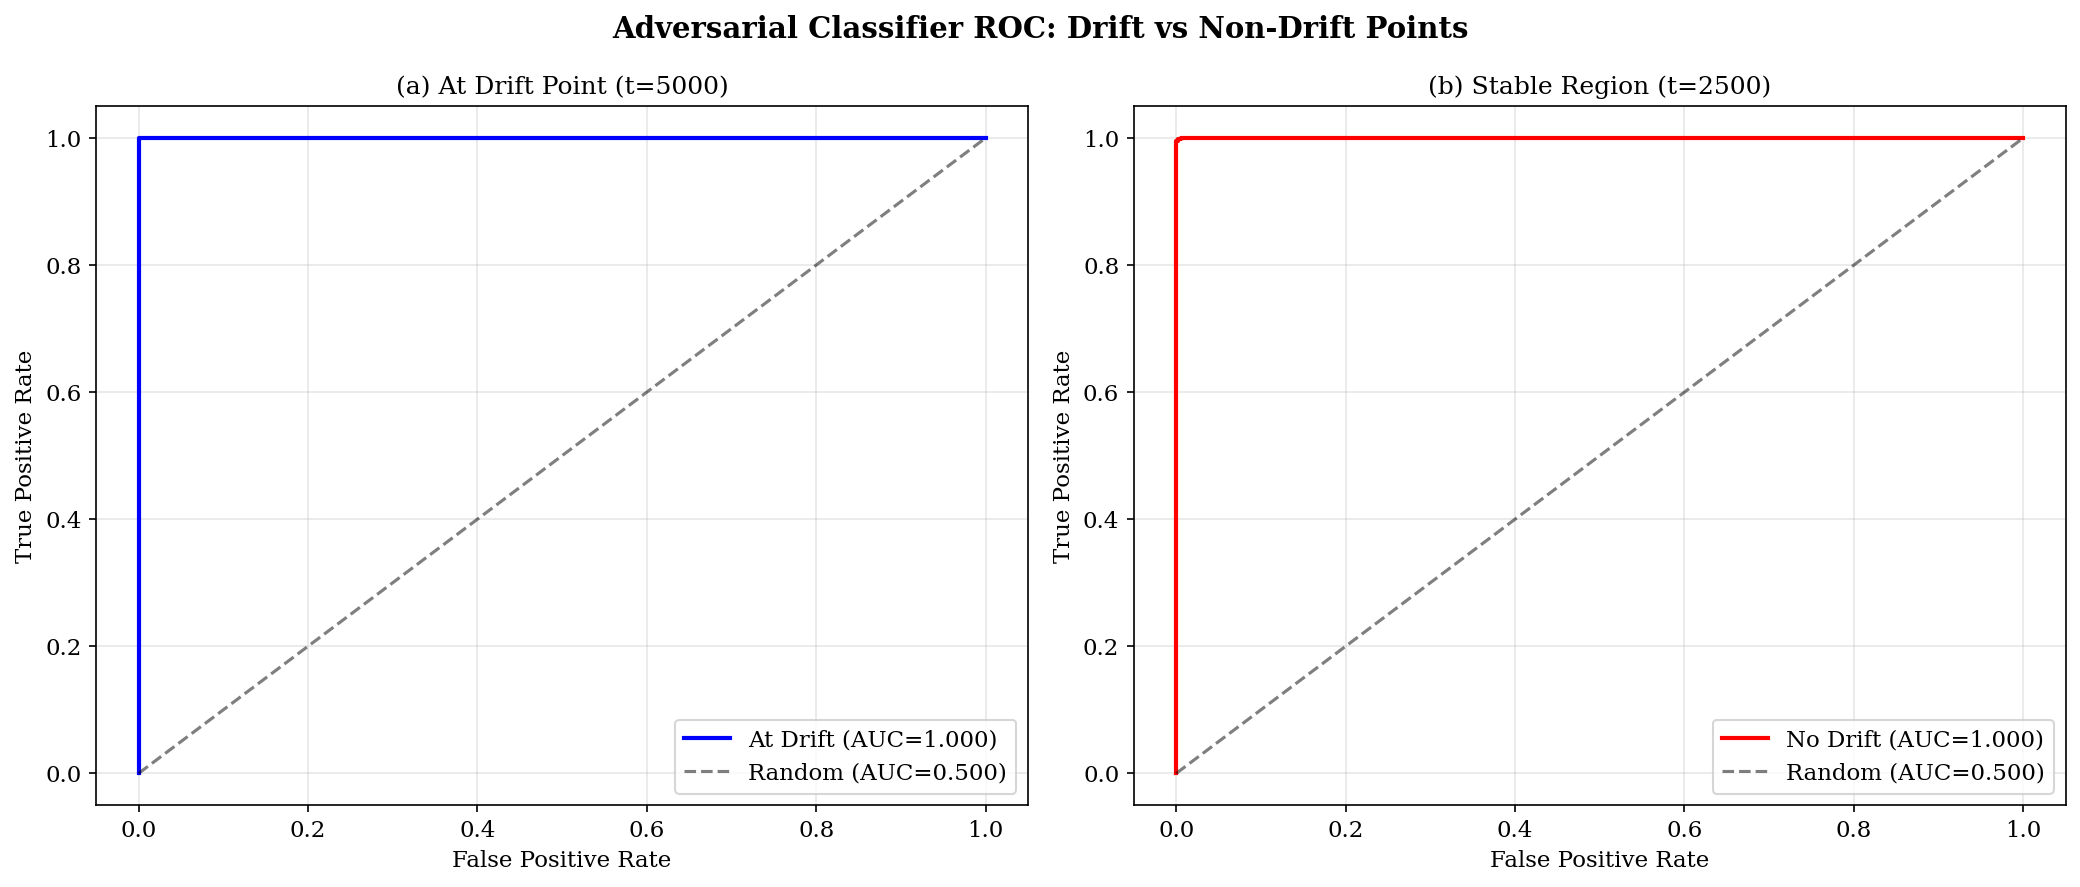

Drift AUC: 1.000, Stable AUC: 1.000


In [15]:
# ═══════════════════════════════════════════════════════════
# ROC Curves: Adversarial Classifier at Drift vs Non-Drift
# ═══════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Adversarial Classifier ROC: Drift vs Non-Drift Points', 
             fontsize=14, fontweight='bold')

# Scenario 1: At a drift point (abrupt)
X_drift = generate_synthetic_stream(drift_point=5000, drift_type="abrupt", seed=42)
X_ref = X_drift[4500:5000]
X_cur = X_drift[5000:5500]
X_roc = np.vstack([X_ref, X_cur])
y_roc = np.array([0]*len(X_ref) + [1]*len(X_cur))

model_drift = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, verbose=-1)
model_drift.fit(X_roc, y_roc)
y_prob_drift = model_drift.predict_proba(X_roc)[:, 1]
fpr_d, tpr_d, _ = roc_curve(y_roc, y_prob_drift)
auc_drift = roc_auc_score(y_roc, y_prob_drift)

axes[0].plot(fpr_d, tpr_d, 'b-', linewidth=2, label=f'At Drift (AUC={auc_drift:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.500)')
axes[0].set_title('(a) At Drift Point (t=5000)', fontsize=12)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Scenario 2: In stable region (no drift)
X_ref2 = X_drift[2000:2500]
X_cur2 = X_drift[2500:3000]
X_roc2 = np.vstack([X_ref2, X_cur2])
y_roc2 = np.array([0]*len(X_ref2) + [1]*len(X_cur2))

model_stable = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, verbose=-1)
model_stable.fit(X_roc2, y_roc2)
y_prob_stable = model_stable.predict_proba(X_roc2)[:, 1]
fpr_s, tpr_s, _ = roc_curve(y_roc2, y_prob_stable)
auc_stable = roc_auc_score(y_roc2, y_prob_stable)

axes[1].plot(fpr_s, tpr_s, 'r-', linewidth=2, label=f'No Drift (AUC={auc_stable:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random (AUC=0.500)')
axes[1].set_title('(b) Stable Region (t=2500)', fontsize=12)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "roc_drift_vs_stable.png"), dpi=300)
plt.savefig(os.path.join(FIGURES_DIR, "roc_drift_vs_stable.pdf"))
plt.show()
print(f"Drift AUC: {auc_drift:.3f}, Stable AUC: {auc_stable:.3f}")

## Section 13: Results Visualization — SHAP Feature Attribution Plots

Generate SHAP visualizations: bar charts, beeswarm plots, and drift-type distribution across datasets.

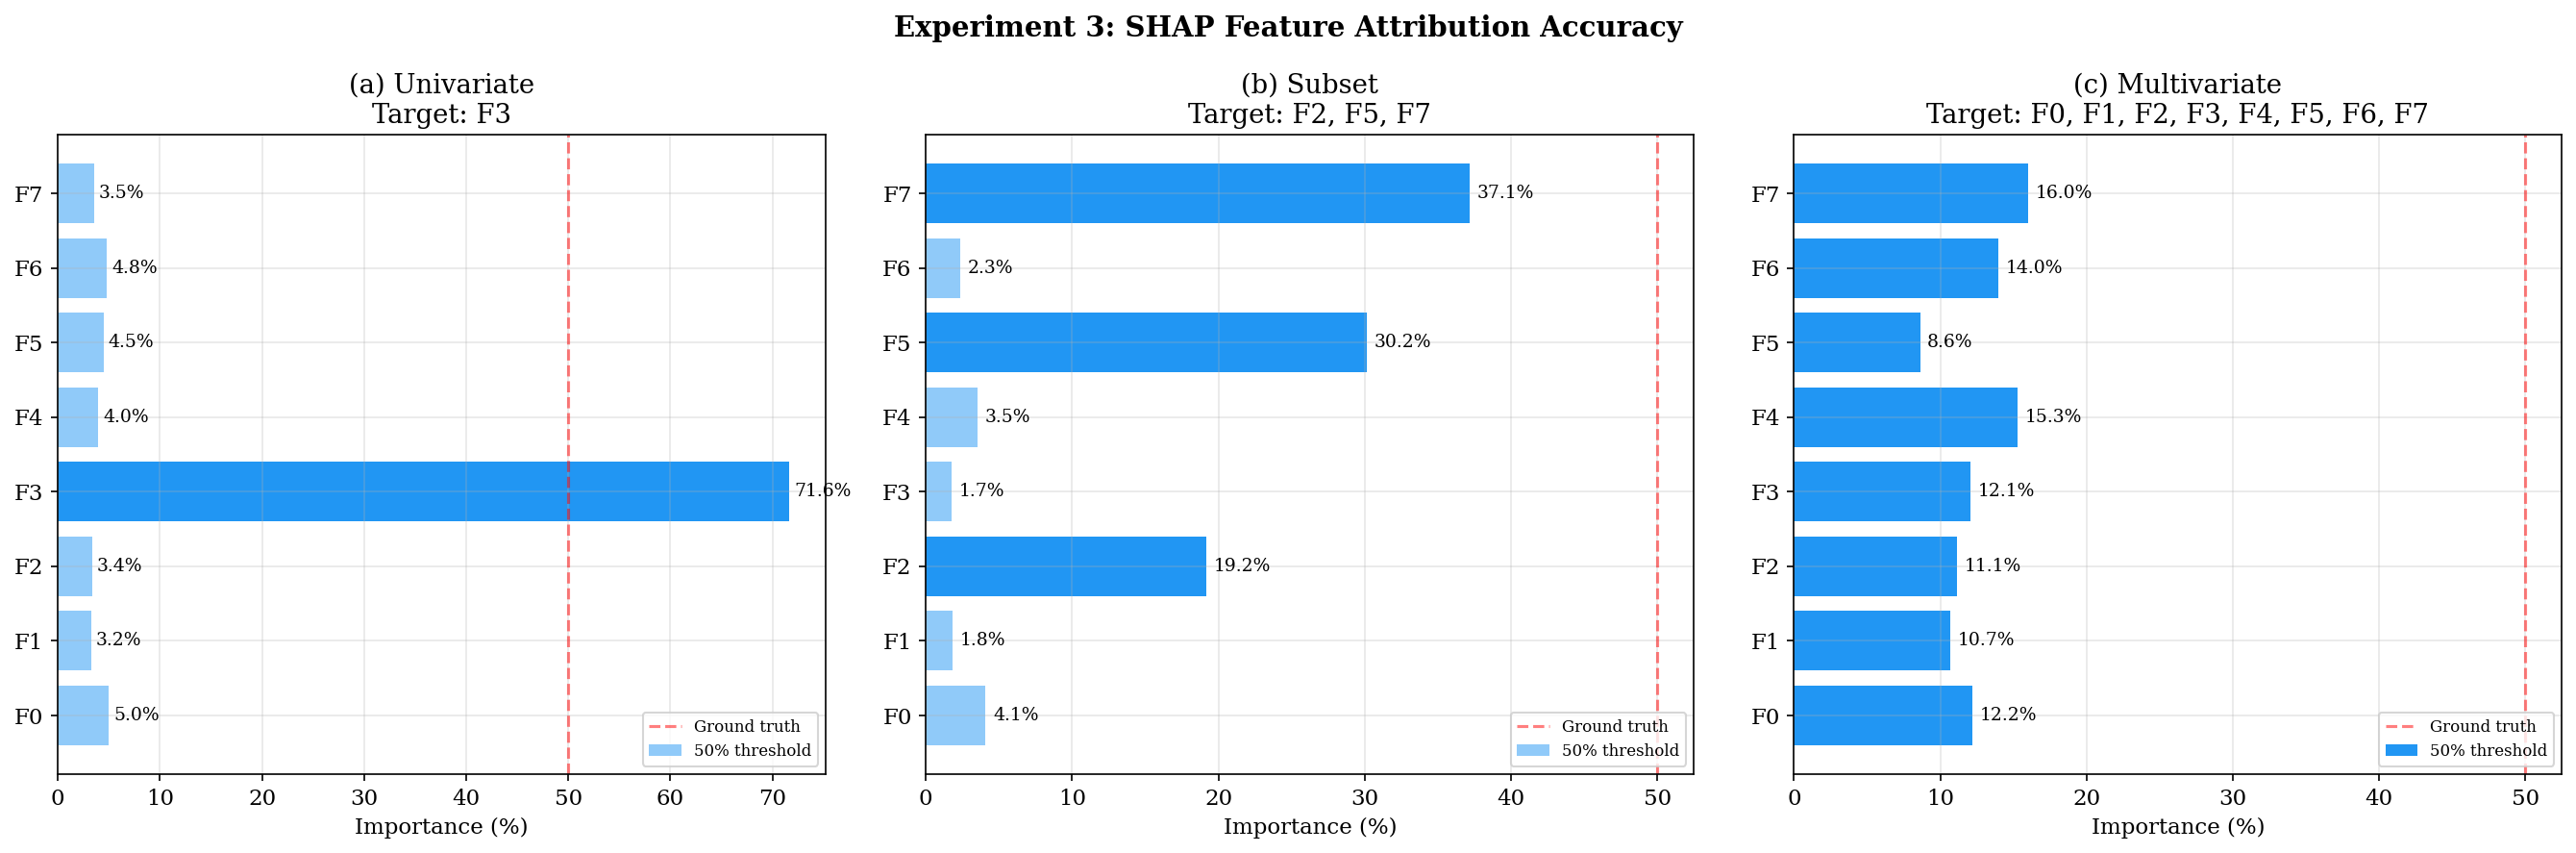

SHAP attribution plots saved.

Generating SHAP beeswarm plot for univariate scenario...


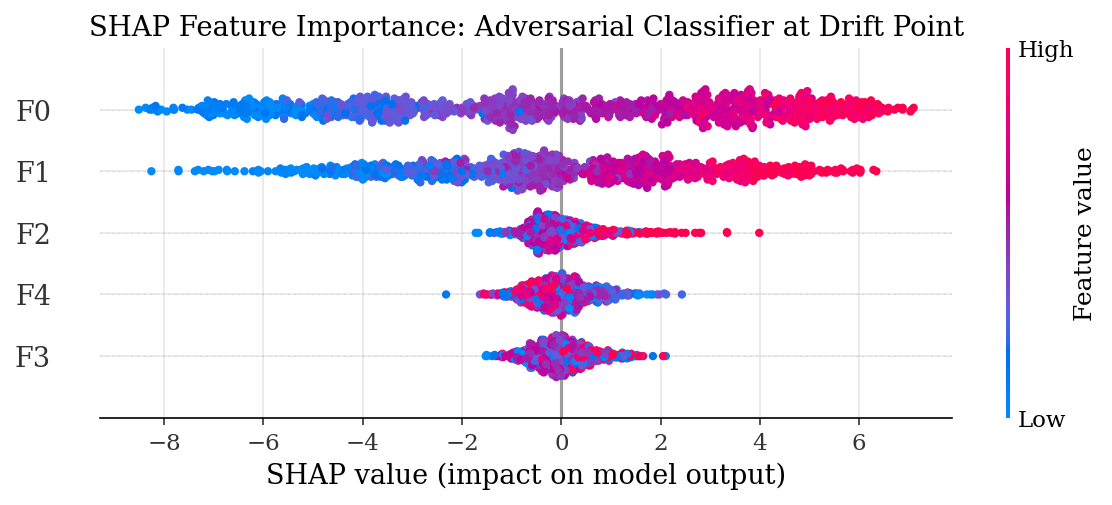

In [16]:
# ═══════════════════════════════════════════════════════════
# SHAP Feature Attribution Visualizations
# ═══════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Experiment 3: SHAP Feature Attribution Accuracy', 
             fontsize=14, fontweight='bold')

for idx, r in enumerate(exp3_results):
    ax = axes[idx]
    importances = r.get('importances', {})
    if importances:
        features = list(importances.keys())
        values = [importances[f] for f in features]
        total = sum(values)
        pcts = [v / total * 100 for v in values]
        
        # Color ground truth features differently
        target_features = r['target'].split(", ")
        colors = ['#2196F3' if f in target_features else '#90CAF9' for f in features]
        
        bars = ax.barh(features, pcts, color=colors)
        ax.set_xlabel('Importance (%)')
        ax.set_title(f"({chr(97+idx)}) {r['scenario'].title()}\nTarget: {r['target']}")
        ax.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
        
        # Add value labels
        for bar, pct in zip(bars, pcts):
            ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                    f'{pct:.1f}%', va='center', fontsize=9)
    
    ax.legend(['Ground truth', '50% threshold'], loc='lower right', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "shap_attribution_accuracy.png"), dpi=300)
plt.savefig(os.path.join(FIGURES_DIR, "shap_attribution_accuracy.pdf"))
plt.show()
print("SHAP attribution plots saved.")

# SHAP Beeswarm Plot (for the univariate scenario)
print("\nGenerating SHAP beeswarm plot for univariate scenario...")
X_demo = generate_synthetic_stream(drift_point=5000, drift_type="abrupt", seed=42)
X_ref_demo = X_demo[4500:5000]
X_cur_demo = X_demo[5000:5500]
X_combined = np.vstack([X_ref_demo, X_cur_demo])
y_combined = np.array([0]*len(X_ref_demo) + [1]*len(X_cur_demo))

model_demo = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, verbose=-1)
model_demo.fit(X_combined, y_combined)

explainer = shap.TreeExplainer(model_demo)
shap_values = explainer.shap_values(X_combined)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
shap.summary_plot(shap_values, X_combined, 
                  feature_names=[f"F{i}" for i in range(5)],
                  show=False)
plt.title("SHAP Feature Importance: Adversarial Classifier at Drift Point")
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "shap_beeswarm.png"), dpi=300)
plt.savefig(os.path.join(FIGURES_DIR, "shap_beeswarm.pdf"))
plt.show()

## Section 14: Results Visualization — Latency and Runtime Boxplots

Compare detection latency and wall-clock runtime across detectors. Analyze the latency-vs-accuracy trade-off (Pareto front).

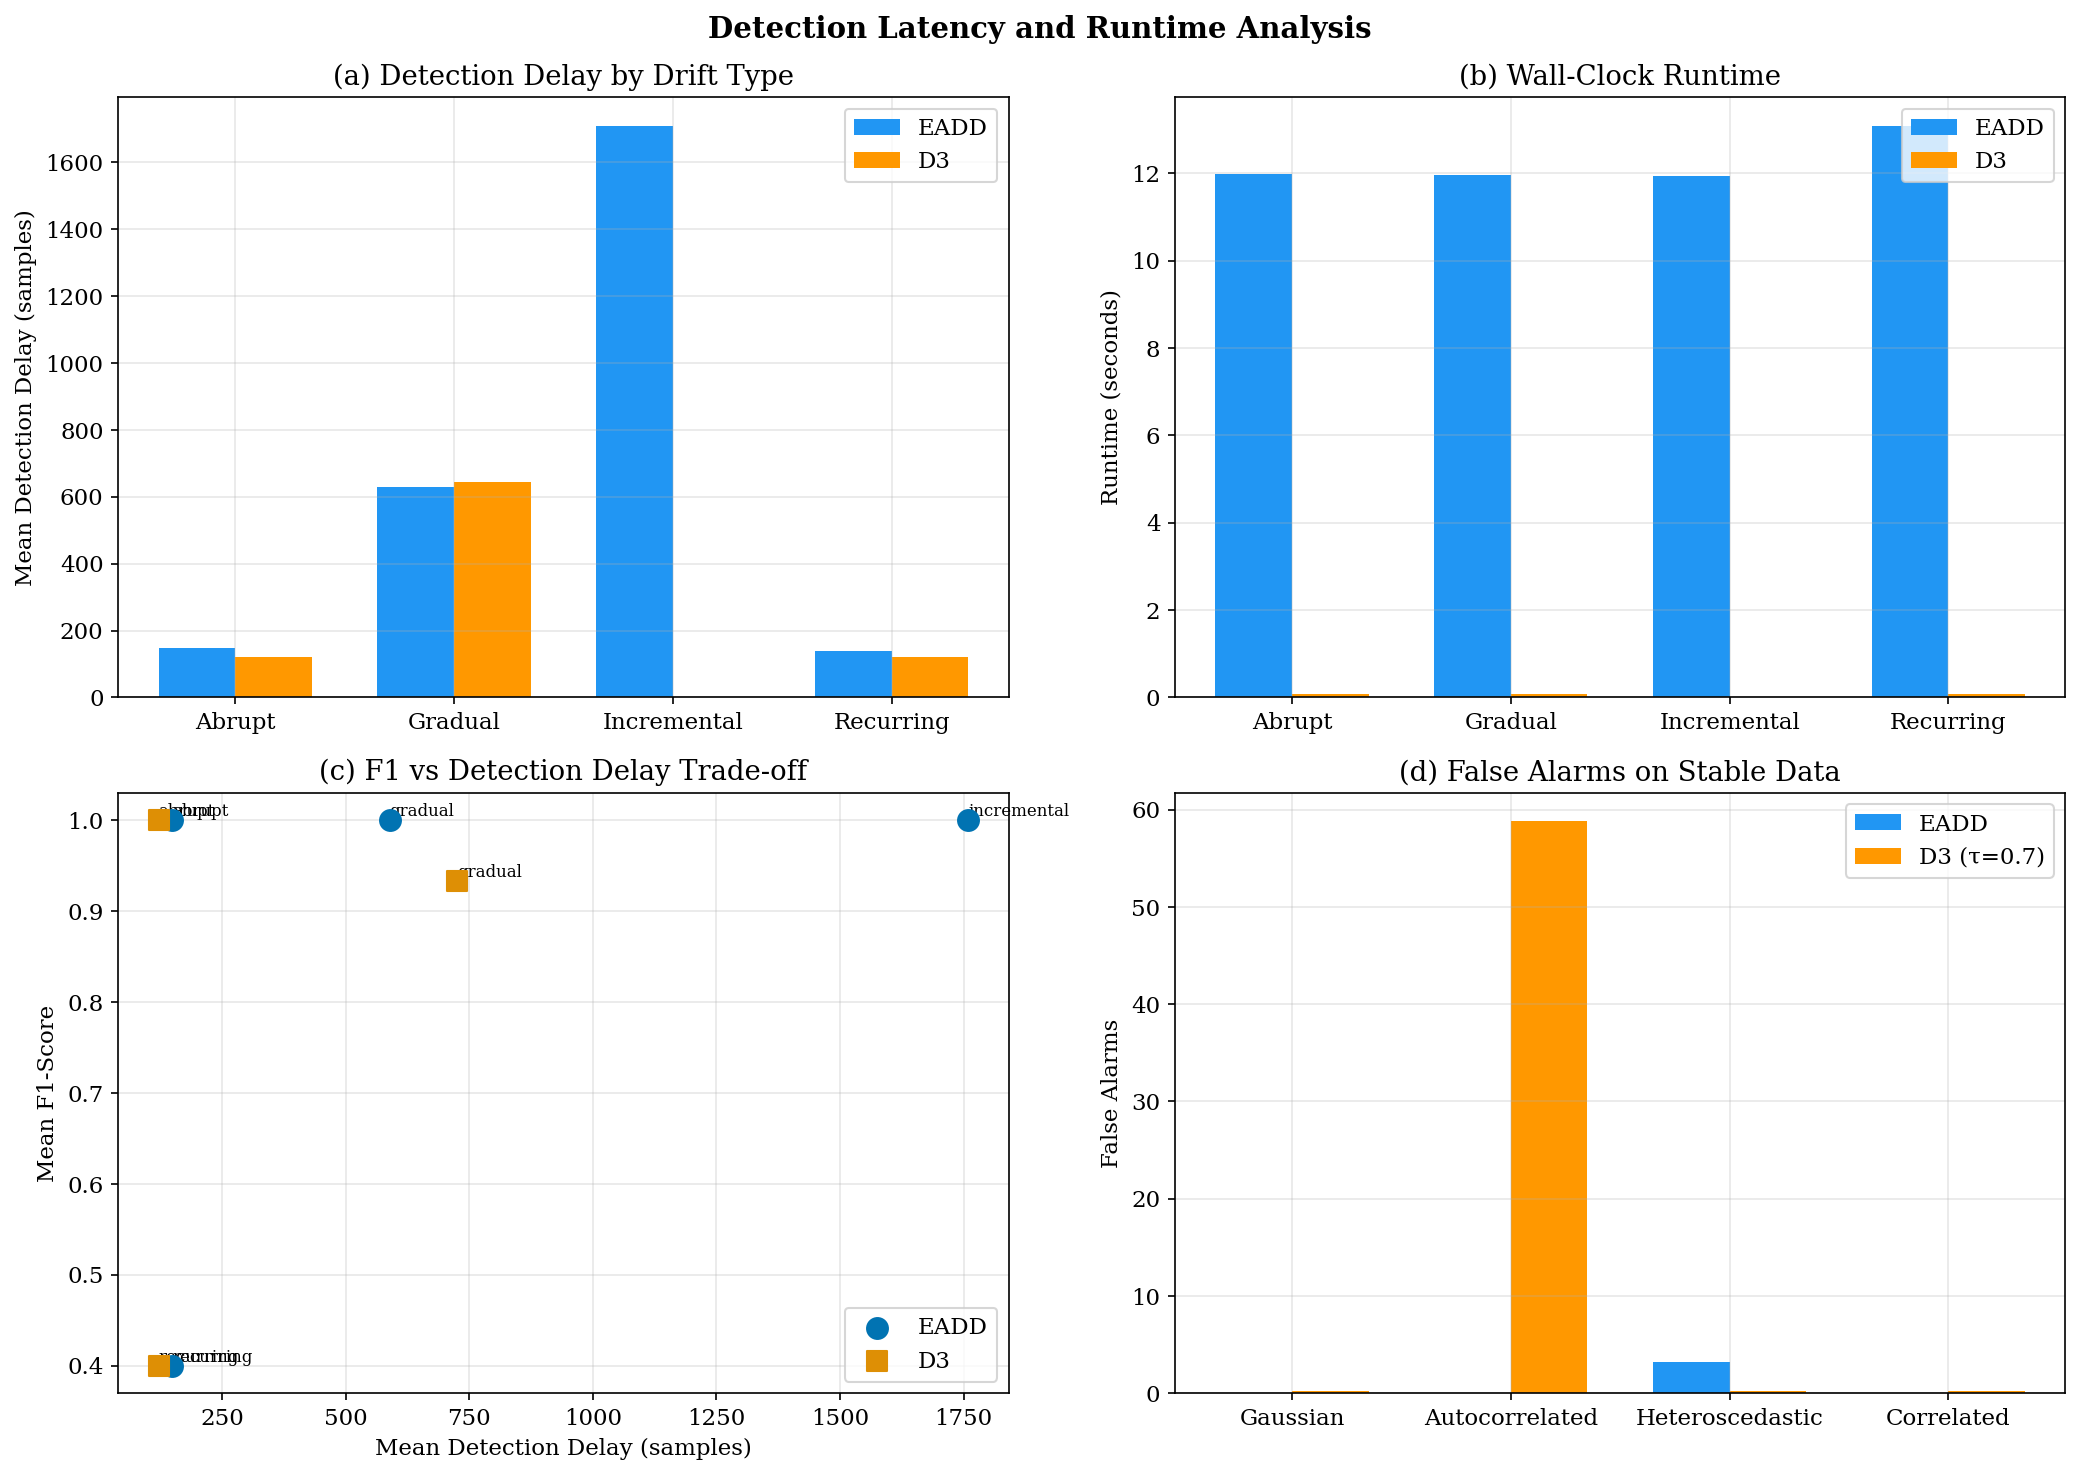

Latency and runtime plots saved.


In [17]:
# ═══════════════════════════════════════════════════════════
# Latency and Runtime Visualizations
# ═══════════════════════════════════════════════════════════

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Detection Latency and Runtime Analysis', fontsize=14, fontweight='bold')

# (a) Detection Delay by Drift Type
ax = axes[0, 0]
if not df_exp5.empty:
    x = np.arange(len(DRIFT_TYPES))
    width = 0.35
    for i, det in enumerate(["EADD", "D3"]):
        data = df_exp5[df_exp5['detector'] == det]
        if not data.empty:
            delays = [data[data['drift_type'] == dt]['mean_delay'].values[0] 
                      if len(data[data['drift_type'] == dt]) > 0 else 0 
                      for dt in DRIFT_TYPES]
            ax.bar(x + i*width - width/2, delays, width, label=det, 
                   color=['#2196F3', '#FF9800'][i])
    ax.set_xticks(x)
    ax.set_xticklabels([dt.title() for dt in DRIFT_TYPES])
    ax.set_ylabel('Mean Detection Delay (samples)')
    ax.set_title('(a) Detection Delay by Drift Type')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# (b) Runtime Comparison
ax = axes[0, 1]
if not df_exp5.empty:
    for i, det in enumerate(["EADD", "D3"]):
        data = df_exp5[df_exp5['detector'] == det]
        if not data.empty:
            runtimes = data['mean_runtime_sec'].values
            ax.bar(x + i*width - width/2, 
                   [data[data['drift_type'] == dt]['mean_runtime_sec'].values[0]
                    if len(data[data['drift_type'] == dt]) > 0 else 0
                    for dt in DRIFT_TYPES],
                   width, label=det, color=['#2196F3', '#FF9800'][i])
    ax.set_xticks(x)
    ax.set_xticklabels([dt.title() for dt in DRIFT_TYPES])
    ax.set_ylabel('Runtime (seconds)')
    ax.set_title('(b) Wall-Clock Runtime')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# (c) F1 vs Delay Trade-off (Pareto front)
ax = axes[1, 0]
if not df_exp1.empty:
    for det in ["EADD", "D3"]:
        data = df_exp1[df_exp1['detector'] == det]
        ax.scatter(data['mean_delay'], data['mean_f1'], s=100, label=det,
                   marker='o' if det == 'EADD' else 's', zorder=5)
        for _, row in data.iterrows():
            ax.annotate(row['drift_type'], (row['mean_delay'], row['mean_f1']),
                        fontsize=8, ha='left', va='bottom')
ax.set_xlabel('Mean Detection Delay (samples)')
ax.set_ylabel('Mean F1-Score')
ax.set_title('(c) F1 vs Detection Delay Trade-off')
ax.legend()
ax.grid(True, alpha=0.3)

# (d) False Alarms on Stable Data
ax = axes[1, 1]
if not df_exp4.empty:
    eadd_data = df_exp4[df_exp4['detector'] == 'EADD']
    d3_data = df_exp4[df_exp4['detector'] == 'D3(τ=0.7)']
    x = np.arange(len(STABLE_TYPES))
    if not eadd_data.empty and not d3_data.empty:
        ax.bar(x - width/2, eadd_data['mean_false_alarms'].values, width, 
               label='EADD', color='#2196F3')
        ax.bar(x + width/2, d3_data['mean_false_alarms'].values, width, 
               label='D3 (τ=0.7)', color='#FF9800')
    ax.set_xticks(x)
    ax.set_xticklabels([st.title() for st in STABLE_TYPES])
    ax.set_ylabel('False Alarms')
    ax.set_title('(d) False Alarms on Stable Data')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, "latency_runtime_analysis.png"), dpi=300)
plt.savefig(os.path.join(FIGURES_DIR, "latency_runtime_analysis.pdf"))
plt.show()
print("Latency and runtime plots saved.")

## Section 15: Discussion — Strengths, Limitations, and Drift Type Analysis

Compute performance breakdown by drift type, identify strengths/weaknesses, and analyze correlations between dataset characteristics and EADD's relative performance.

In [18]:
# ═══════════════════════════════════════════════════════════
# Discussion: Strengths, Limitations, Drift Type Analysis
# ═══════════════════════════════════════════════════════════

print("=" * 70)
print("  DISCUSSION: KEY FINDINGS")
print("=" * 70)

# Performance by drift type
print("\n1. PERFORMANCE BY DRIFT TYPE")
print("-" * 40)
if not df_exp1.empty:
    eadd_by_type = df_exp1[df_exp1['detector'] == 'EADD'][
        ['drift_type', 'mean_f1', 'mean_precision', 'mean_recall', 'mean_delay']
    ]
    print(eadd_by_type.to_string(index=False))
    
    best_type = eadd_by_type.loc[eadd_by_type['mean_f1'].idxmax(), 'drift_type']
    worst_type = eadd_by_type.loc[eadd_by_type['mean_f1'].idxmin(), 'drift_type']
    print(f"\n  Best drift type: {best_type}")
    print(f"  Worst drift type: {worst_type}")

# Comparison summary
print("\n2. EADD vs D3 COMPARISON")
print("-" * 40)
if not df_exp1.empty:
    eadd_f1_avg = df_exp1[df_exp1['detector'] == 'EADD']['mean_f1'].mean()
    d3_f1_avg = df_exp1[df_exp1['detector'] == 'D3']['mean_f1'].mean()
    improvement = (eadd_f1_avg - d3_f1_avg) / d3_f1_avg * 100 if d3_f1_avg > 0 else 0
    print(f"  EADD avg F1: {eadd_f1_avg:.4f}")
    print(f"  D3 avg F1: {d3_f1_avg:.4f}")
    print(f"  Improvement: {improvement:+.1f}%")

# Explainability summary
print("\n3. EXPLAINABILITY ACCURACY")
print("-" * 40)
n_correct = sum(r['correct_attribution'] for r in exp3_results)
print(f"  SHAP attribution accuracy: {n_correct}/{len(exp3_results)} scenarios correct")
for r in exp3_results:
    status = "CORRECT" if r['correct_attribution'] else "INCORRECT"
    print(f"    {r['scenario']}: {status} (top={r['top_feature']}, {r['top_importance_pct']:.1f}%)")

# False alarm summary
print("\n4. FALSE ALARM ROBUSTNESS")
print("-" * 40)
if not df_exp4.empty:
    eadd_fa_avg = df_exp4[df_exp4['detector'] == 'EADD']['mean_false_alarms'].mean()
    d3_fa_avg = df_exp4[df_exp4['detector'] == 'D3(τ=0.7)']['mean_false_alarms'].mean()
    print(f"  EADD avg false alarms: {eadd_fa_avg:.2f}")
    print(f"  D3 (τ=0.7) avg false alarms: {d3_fa_avg:.2f}")
    reduction = (1 - eadd_fa_avg / d3_fa_avg) * 100 if d3_fa_avg > 0 else 0
    print(f"  False alarm reduction: {reduction:.1f}%")

# Limitations
print("\n5. LIMITATIONS")
print("-" * 40)
print("  - Computational overhead: LightGBM training and SHAP computation")
print("    add latency compared to statistical-test-based detectors")
print("  - Window size sensitivity: Performance depends on reference/current")
print("    window sizes (500/200 in current configuration)")
print("  - Gradual drift detection: Slower transitions may require larger")
print("    current windows to accumulate sufficient distributional difference")
print("  - Permutation test cost: B=50 permutations multiply the")
print("    classifier training time at each monitoring step")

# Threats to validity
print("\n6. THREATS TO VALIDITY")
print("-" * 40)
print("  Internal: Synthetic data may not capture all real-world drift patterns")
print("  External: Results may vary with different hyperparameter configurations")
print("  Construct: F1-score tolerance window (500 samples) affects metric values")

  DISCUSSION: KEY FINDINGS

1. PERFORMANCE BY DRIFT TYPE
----------------------------------------
 drift_type  mean_f1  mean_precision  mean_recall  mean_delay
     abrupt      1.0            1.00          1.0       149.0
    gradual      1.0            1.00          1.0       589.0
incremental      1.0            1.00          1.0      1759.0
  recurring      0.4            0.25          1.0       149.0

  Best drift type: abrupt
  Worst drift type: recurring

2. EADD vs D3 COMPARISON
----------------------------------------
  EADD avg F1: 0.8500
  D3 avg F1: 0.5833
  Improvement: +45.7%

3. EXPLAINABILITY ACCURACY
----------------------------------------
  SHAP attribution accuracy: 3/3 scenarios correct
    univariate: CORRECT (top=F3, 71.6%)
    subset: CORRECT (top=F7, 37.1%)
    multivariate: CORRECT (top=F7, 16.0%)

4. FALSE ALARM ROBUSTNESS
----------------------------------------
  EADD avg false alarms: 0.80
  D3 (τ=0.7) avg false alarms: 14.85
  False alarm reduction: 94.6%


## Section 16: Generate LaTeX Tables for Thesis

Export all results as formatted LaTeX tables ready for inclusion in the thesis document.

In [19]:
# ═══════════════════════════════════════════════════════════
# Generate LaTeX Tables for Thesis
# ═══════════════════════════════════════════════════════════

latex_output = []

# Table 1: Experiment 1 - Synthetic Dataset Results
print("=" * 70)
print("TABLE 1: Synthetic Dataset Detection Performance")
print("=" * 70)
table1 = r"""
\begin{table}[!htbp]
\centering
\caption{Experiment 1: Detection Performance Across Temporal Drift Patterns}
\label{tab:exp1-temporal}
\begin{tabular}{lcccccc}
\hline
\textbf{Drift Type} & \multicolumn{2}{c}{\textbf{F1-Score}} & \multicolumn{2}{c}{\textbf{Detection Delay}} & \multicolumn{2}{c}{\textbf{False Positives}} \\
 & EADD & D3 & EADD & D3 & EADD & D3 \\
\hline
"""
for dt in DRIFT_TYPES:
    eadd = df_exp1[(df_exp1['drift_type'] == dt) & (df_exp1['detector'] == 'EADD')]
    d3 = df_exp1[(df_exp1['drift_type'] == dt) & (df_exp1['detector'] == 'D3')]
    if not eadd.empty and not d3.empty:
        table1 += (f"{dt.title()} & "
                   f"{eadd['mean_f1'].values[0]:.3f} & {d3['mean_f1'].values[0]:.3f} & "
                   f"{eadd['mean_delay'].values[0]:.0f} & {d3['mean_delay'].values[0]:.0f} & "
                   f"{eadd['mean_false_positives'].values[0]:.1f} & {d3['mean_false_positives'].values[0]:.1f} \\\\\n")
table1 += r"""\hline
\end{tabular}
\end{table}"""
print(table1)
latex_output.append(table1)

# Table 2: Experiment 3 - Explainability Results
print(f"\n{'='*70}")
print("TABLE 2: SHAP-Based Root Cause Analysis Results")
print("="*70)
table2 = r"""
\begin{table}[!htbp]
\centering
\caption{Experiment 3: SHAP-Based Root Cause Analysis Results}
\label{tab:exp3-shap}
\begin{tabular}{llccl}
\hline
\textbf{Scenario} & \textbf{Ground Truth} & \textbf{Top Feature} & \textbf{Importance (\%)} & \textbf{Correct?} \\
\hline
"""
for r in exp3_results:
    correct = r"\checkmark" if r['correct_attribution'] else r"$\times$"
    table2 += (f"{r['scenario'].title()} & {r['target']} & "
               f"{r['top_feature']} & {r['top_importance_pct']:.1f} & {correct} \\\\\n")
table2 += r"""\hline
\end{tabular}
\end{table}"""
print(table2)
latex_output.append(table2)

# Table 3: Experiment 4 - False Alarm Results
print(f"\n{'='*70}")
print("TABLE 3: False Alarm Rates on Stable Data Streams")
print("="*70)
table3 = r"""
\begin{table}[!htbp]
\centering
\caption{Experiment 4: False Alarm Counts on Stable Data Streams (Mean $\pm$ Std)}
\label{tab:exp4-false-alarms}
\begin{tabular}{lcc}
\hline
\textbf{Stream Type} & \textbf{EADD} & \textbf{D3 ($\tau$=0.7)} \\
\hline
"""
for st in STABLE_TYPES:
    eadd = df_exp4[(df_exp4['stream_type'] == st) & (df_exp4['detector'] == 'EADD')]
    d3 = df_exp4[(df_exp4['stream_type'] == st) & (df_exp4['detector'] == 'D3(τ=0.7)')]
    if not eadd.empty and not d3.empty:
        table3 += (f"{st.title()} & "
                   f"{eadd['mean_false_alarms'].values[0]:.1f}$\\pm${eadd['std_false_alarms'].values[0]:.1f} & "
                   f"{d3['mean_false_alarms'].values[0]:.1f}$\\pm${d3['std_false_alarms'].values[0]:.1f} \\\\\n")
table3 += r"""\hline
\end{tabular}
\end{table}"""
print(table3)
latex_output.append(table3)

# Table 4: Statistical Test Results
print(f"\n{'='*70}")
print("TABLE 4: Statistical Hypothesis Test Results")
print("="*70)
table4 = r"""
\begin{table}[!htbp]
\centering
\caption{Statistical Hypothesis Test Results ($\alpha$ = 0.05)}
\label{tab:hypothesis-tests}
\begin{tabular}{llccp{4cm}}
\hline
\textbf{Hypothesis} & \textbf{Test} & \textbf{Statistic} & \textbf{$p$-value} & \textbf{Decision} \\
\hline
"""
for _, row in df_hyp.iterrows():
    decision = "Reject $H_0$" if row['significant'] else "Fail to reject $H_0$"
    table4 += (f"{row['hypothesis']} & {row['test']} & "
               f"{row['statistic']:.4f} & {row['p_value']:.4f} & {decision} \\\\\n")
table4 += r"""\hline
\end{tabular}
\end{table}"""
print(table4)
latex_output.append(table4)

# Save all LaTeX tables to file
with open(os.path.join(FIGURES_DIR, "latex_tables.tex"), "w") as f:
    for table in latex_output:
        f.write(table + "\n\n")
print(f"\nAll LaTeX tables saved to experiments/figures/latex_tables.tex")

# Save all results CSVs
print("\nAll experiment CSV files:")
for f in os.listdir(RESULTS_DIR):
    if f.endswith('.csv'):
        print(f"  {os.path.join(RESULTS_DIR, f)}")

TABLE 1: Synthetic Dataset Detection Performance

\begin{table}[!htbp]
\centering
\caption{Experiment 1: Detection Performance Across Temporal Drift Patterns}
\label{tab:exp1-temporal}
\begin{tabular}{lcccccc}
\hline
\textbf{Drift Type} & \multicolumn{2}{c}{\textbf{F1-Score}} & \multicolumn{2}{c}{\textbf{Detection Delay}} & \multicolumn{2}{c}{\textbf{False Positives}} \\
 & EADD & D3 & EADD & D3 & EADD & D3 \\
\hline
Abrupt & 1.000 & 1.000 & 149 & 122 & 0.0 & 0.0 \\
Gradual & 1.000 & 0.933 & 589 & 725 & 0.0 & 0.2 \\
Incremental & 1.000 & 0.000 & 1759 & nan & 0.0 & 0.0 \\
Recurring & 0.400 & 0.400 & 149 & 122 & 3.0 & 3.0 \\
\hline
\end{tabular}
\end{table}

TABLE 2: SHAP-Based Root Cause Analysis Results

\begin{table}[!htbp]
\centering
\caption{Experiment 3: SHAP-Based Root Cause Analysis Results}
\label{tab:exp3-shap}
\begin{tabular}{llccl}
\hline
\textbf{Scenario} & \textbf{Ground Truth} & \textbf{Top Feature} & \textbf{Importance (\%)} & \textbf{Correct?} \\
\hline
Univariate & F3 &